# FEEMS vs IBD on Anisotropic Map

This is an attempt to find a scenario where using FEEMS estimated migration provide more accurate/calibrated spatial prediction than isolation by distance (which we approximate with a fit FEEMS model with constant edge weights).

Here we create a highly anisotropic migration surface (left/right migration is much easier than up/down migration). We'd like to see that FEEMS

We generate a 8×16 2D map and simulate 2000 SNPs. We sample 10 individuals at each deme. We evaluate the relative performance of FEEMS and IBD via "leave-one-deme-out" spatial prediction. That is, we exclude all the samples from one deme, fit FEEMS using all other samples, and then assign the samples we held out using the fit FEEMS model.

We compare the performance of FEEMS an IBD while fitting both models using a subset of 100, 500, or 1000 SNPs. FEEMS and IBD do not perform perceptably different here, prediction error predictably goes down as we include more SNPs.

In [1]:
import sys
sys.path.append("../")

In [2]:
from scripts.coalescent_sim import *
from feems import SpatialGraph, Viz
import cartopy.crs as ccrs
from feems.cross_validation import run_cv, train_test_split
from feems.spatial_prediction import predict_deme_point_mu
from feems.spatial_graph import query_node_attributes

from tqdm import tqdm

In [3]:
graph, coord, grid, edges = setup_graph(
    n_rows=8, 
    n_columns=16, 
    barrier_startpt=0, 
    barrier_endpt=0,
    anisotropy_scaler=10.0,
    barrier_w=.1, 
    corridor_w=.5, 
    n_samples_per_node=10,
    barrier_prob=.1, 
    corridor_left_prob=1,
    corridor_right_prob=1,
    sample_prob=1.0
)

In [4]:
%%time
np.random.seed(0)
genotypes = simulate_genotypes(
    graph,
    chrom_length=1,
    mu=1e-3, n_e=1,
    target_n_snps=2000
)
D = np.sqrt(((grid[:, None] - grid[None])**2).sum(-1))

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950
Simulating ~SNP 1000
Simulating ~SNP 1050
Simulating ~SNP 1100
Simulating ~SNP 1150
Simulating ~SNP 1200
Simulating ~SNP 1250
Simulating ~SNP 1300
Simulating ~SNP 1350
Simulating ~SNP 1400
Simulating ~SNP 1450
Simulating ~SNP 1500
Simulating ~SNP 1550
Simulating ~SNP 1600
Simulating ~SNP 1650
Simulating ~SNP 1700
Simulating ~SNP 1750
Simulating ~SNP 1800
Simulating ~SNP 1850
Simulating ~SNP 1900
Simulating ~SNP 1950
CPU times: user 16min 39s, sys: 2.24 s, total: 16min 41s
Wall time: 16min 45s


In [6]:
#np.savetxt("anisotropic_genotypes.tsv", genotypes, delimiter="\t")

In [121]:
np.random.choice(D[0], 3)

array([ 7.81024968, 10.58300524, 14.73091986])

In [197]:
def compute_average_error(true_nodes, z, D):
    return (D[true_nodes] * np.exp(z)).sum(1)

def split_n_fit(genotypes, coord, grid, edges, is_train):
    # initialize spatial graph, then split into train/test
    sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)
    sp_graph_train, sp_graph_test = train_test_split(sp_graph, is_train)

    # fit null model, get predictions from null model
    sp_graph_train.fit_null_model()
    z_ibd, post_mean_ibd = predict_deme_point_mu(
        genotypes[~is_train], sp_graph_train)
    
    # fit feems
    sp_graph_train.fit(lamb=1.0)
    z_feems, post_mean_feems = predict_deme_point_mu(
        genotypes[~is_train], sp_graph_train)
    
    perm_idx = query_node_attributes(sp_graph_train, 'permuted_idx')
    inv_perm_idx = np.argsort(perm_idx)  # undo permutation of nodes
    
    return dict(
        z_feems=z_feems[:, inv_perm_idx],
        post_mean_feems=post_mean_feems,
        z_ibd=z_ibd[:, inv_perm_idx],
        post_mean_ibd=post_mean_ibd,
        is_train=is_train,
        coord=coord,
        sp_graph=sp_graph_train,
        sp_graph_test=sp_graph_test
    )


def leave_node_out(genotypes, coord, grid, edges):
    D = np.sqrt(((grid[:, None] - grid[None])**2).sum(-1))
    d_z_feems = {}
    d_z_ibd = {}
    d_z_perm = {}

    for i, g in tqdm(enumerate(grid)):
        try:
            is_train = ~np.array([np.allclose(x, g) for x in coord])
            results = split_n_fit(genotypes, coord, grid, edges, is_train)
            d_z_feems[i] = (D[i] * np.exp(results['z_feems'])).sum(1)
            d_z_ibd[i] = (D[i] * np.exp(results['z_ibd'])).sum(1)
            d_z_perm[i] = np.random.choice(D[i], results['z_ibd'].shape[0])
        except:
            pass
    return d_z_feems, d_z_ibd, d_z_perm

        
        
def run_sim(genotypes, n_snps, boundary):
    assert (n_snps < genotypes.shape[1])
    idx = np.random.choice(genotypes.shape[1], n_snps, replace=False)
    G = genotypes[:, idx]
    sp_graph = SpatialGraph(G, coord, grid, edges, scale_snps=True)

    is_train = coord[:, 0] < boundary
    sp_graph.factor = None
    sp_graph_train, sp_graph_test = train_test_split(sp_graph, is_train)

    # fit null model, get predictions from null model
    sp_graph_train.fit_null_model()
    z_ibd, post_mean_ibd = predict_deme_point_mu(G[~is_train], sp_graph_train)


    sp_graph_train.fit(lamb=1.0)
    z_feems, post_mean_feems = predict_deme_point_mu(G[~is_train], sp_graph_train)
    
    nodes = sp_graph.assned_node_idx[~is_train]

    perm_idx = query_node_attributes(sp_graph_train, 'permuted_idx')
    inv_perm_idx = np.argsort(perm_idx)  # undo permutation of nodes
    ibd_error = compute_average_error(nodes, z_ibd[:, inv_perm_idx], D)
    feems_error = compute_average_error(nodes, z_feems[:, inv_perm_idx], D)

    perm = np.concatenate([np.random.permutation(a) for a in [left, middle, right]])
    z_perm = z_feems[:, inv_perm_idx][:, perm]
    perm_error = compute_average_error(nodes, z_perm, D)

    return {
        'ibd_error': ibd_error,
        'feems_error': feems_error,
        'perm_error': perm_error,

        'nodes': nodes,
        'node_pos': grid[nodes]
    }

In [105]:
snps = np.random.choice(genotypes.shape[1], 1000)
is_train = ~np.array([np.allclose(x, grid[20]) for x in coord])
results = split_n_fit(genotypes[:, snps], coord, grid, edges, is_train)

constant-w/variance fit, converged in 115 iterations, train_loss=-12709.1408617
constant-w/variance fit, converged in 115 iterations, train_loss=-12709.1408617
lambda=1.0000000, alpha=0.4732923, converged in 16 iterations, train_loss=-16427.3589512


In [117]:
(D[0][None] * np.exp(results['z_feems'])).sum(1)

array([4.69494439, 6.122082  , 4.78956917, 4.78325518, 6.99291559,
       4.76805004, 4.57846421, 5.37481492, 5.66654853, 4.20093344])

In [118]:
(D[0][None] * np.exp(results['z_ibd'])).sum(1)

array([4.69203196, 6.17813308, 4.98249065, 4.78290539, 7.76252121,
       4.93426081, 4.52076475, 5.27069347, 5.65118303, 3.84105761])

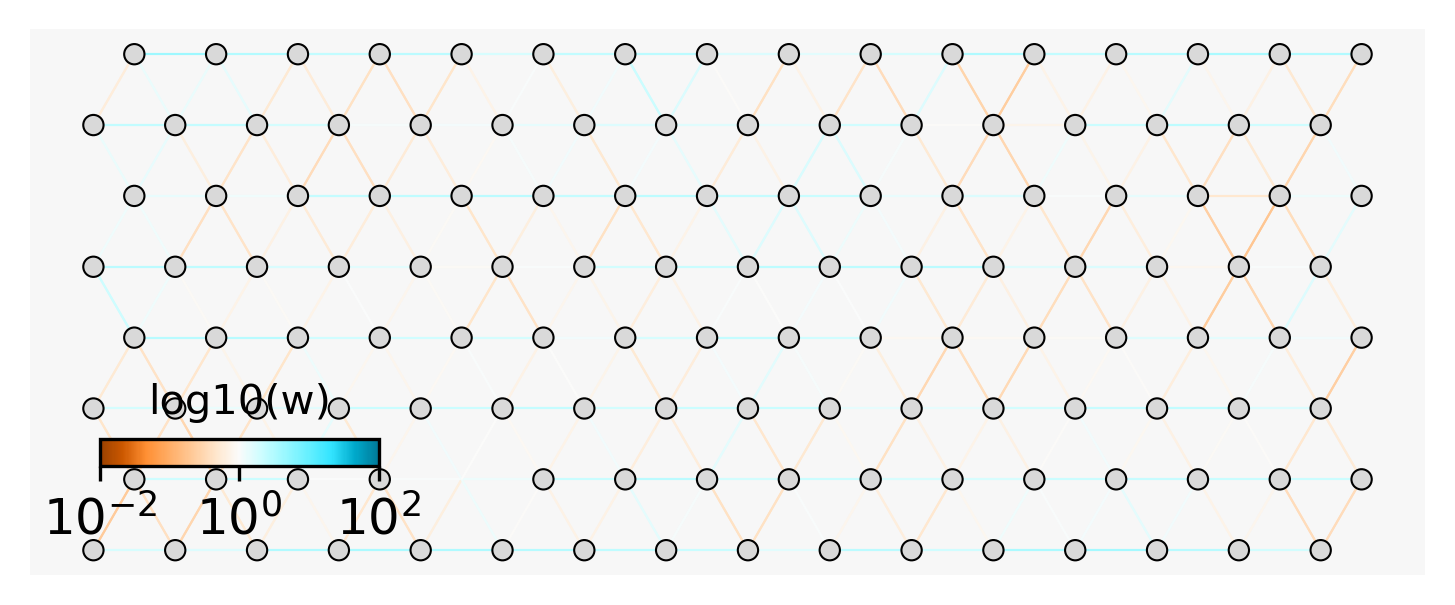

In [106]:
fig = plt.figure(dpi=300)
projection = ccrs.EquidistantConic()
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, results['sp_graph'], projection=None, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)

v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()
#draw_points(c)

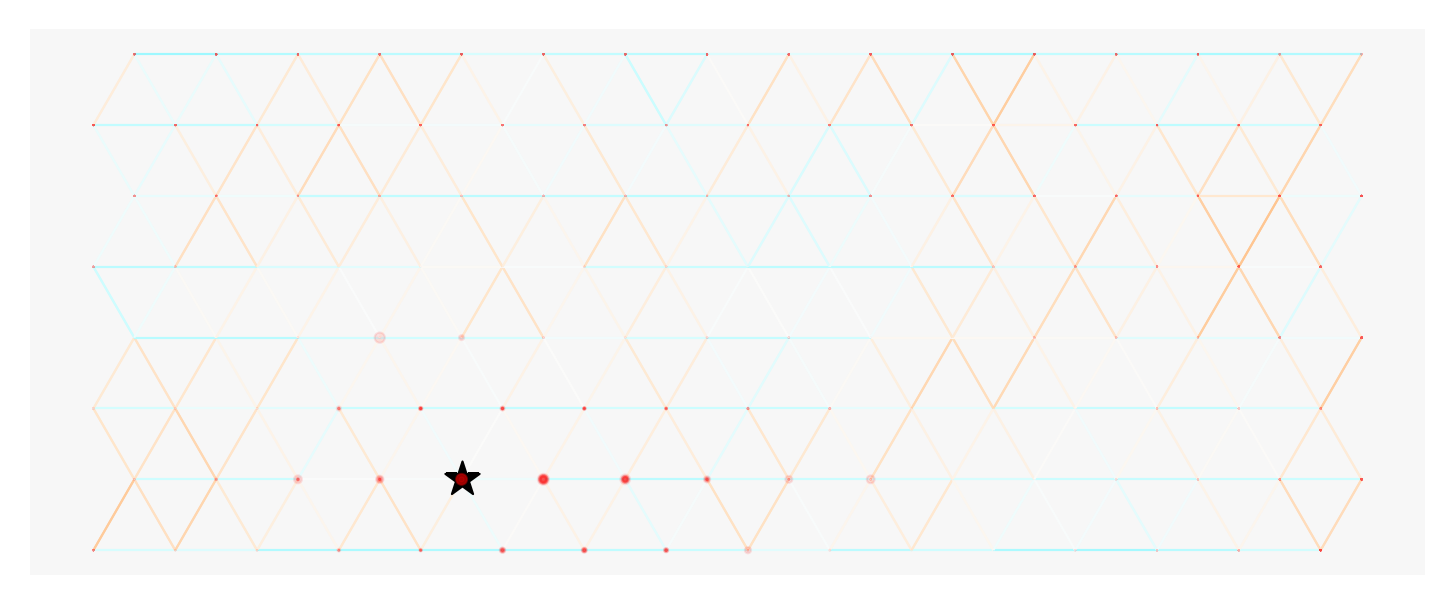

In [107]:
def draw_z(self, coord, z, color):
    """Draw the observed node coordinates"""
    self.ax.scatter(
        coord[:, 0],
        coord[:, 1],
        edgecolors=color,
        linewidth=self.obs_node_linewidth,
        s=self.obs_node_size * np.sqrt(np.exp(z)),
        alpha=0.1,
        color=color,
        zorder=self.obs_node_zorder,
    )

def draw_distinguished_nodes(self, coord, color):
    """Draw the observed node coordinates"""
    coord = np.atleast_2d(coord)
    self.ax.scatter(
        coord[:, 0],
        coord[:, 1],
        edgecolors='black',
        linewidth=self.obs_node_linewidth,
        s=self.obs_node_size * 10,
        color=color,
        marker='*',
        zorder=self.obs_node_zorder,
    )

fig = plt.figure(dpi=300)
projection = ccrs.EquidistantConic()
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, results['sp_graph'], projection=None, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)

v.draw_map()
v.draw_edges(use_weights=True)
draw_distinguished_nodes(v, grid[20], 'black')
[draw_z(v, grid, z, 'red') for z in results['z_feems']];

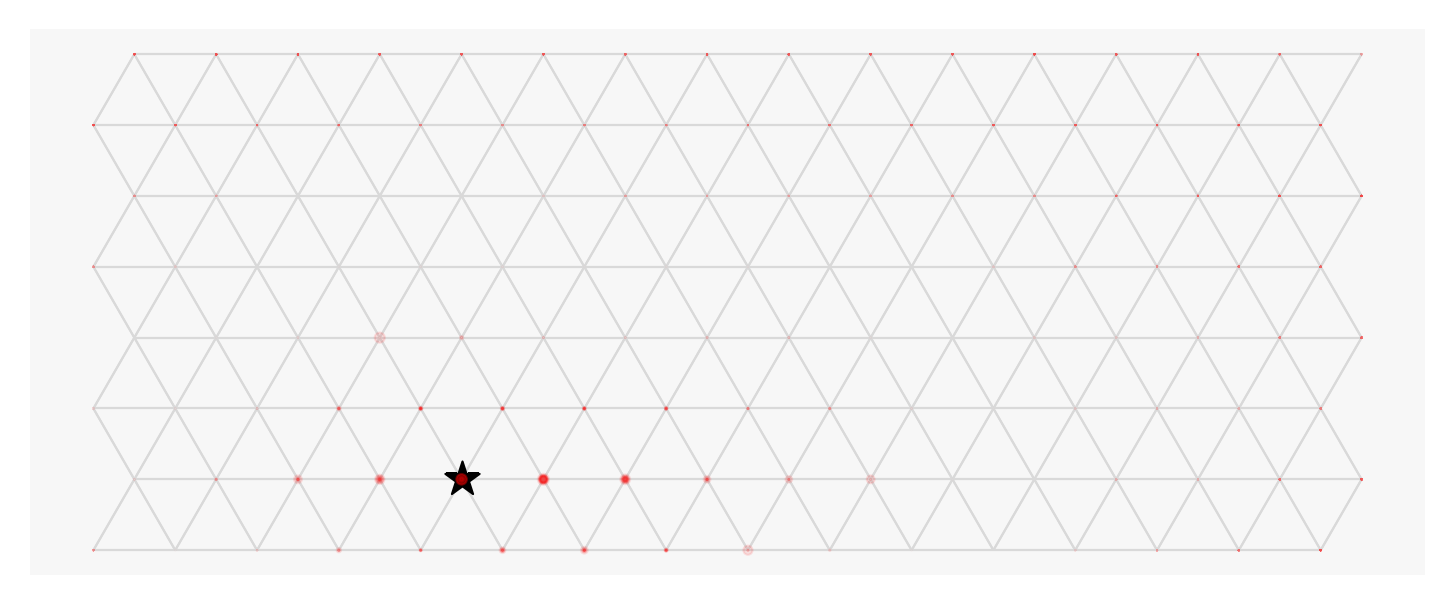

In [108]:
fig = plt.figure(dpi=300)
projection = ccrs.EquidistantConic()
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, results['sp_graph'], projection=None, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)

v.draw_map()
v.draw_edges(use_weights=False)
draw_distinguished_nodes(v, grid[20], 'black')
[draw_z(v, grid, z, 'red') for z in results['z_ibd']];

0it [00:00, ?it/s]

constant-w/variance fit, converged in 111 iterations, train_loss=-814.6278699


1it [00:02,  2.03s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-814.6278699
lambda=1.0000000, alpha=0.5304652, converged in 20 iterations, train_loss=-1280.9954181
constant-w/variance fit, converged in 107 iterations, train_loss=-737.1954551


2it [00:04,  2.01s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-737.1954551
lambda=1.0000000, alpha=0.5245654, converged in 19 iterations, train_loss=-1189.9308770
constant-w/variance fit, converged in 113 iterations, train_loss=-774.3106191


3it [00:06,  2.08s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-774.3106191
lambda=1.0000000, alpha=0.5255875, converged in 20 iterations, train_loss=-1239.0562624
constant-w/variance fit, converged in 106 iterations, train_loss=-739.5227751


4it [00:08,  2.06s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-739.5227751
lambda=1.0000000, alpha=0.5298538, converged in 19 iterations, train_loss=-1195.4806069
constant-w/variance fit, converged in 103 iterations, train_loss=-748.8308070


5it [00:10,  2.04s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-748.8308070
lambda=1.0000000, alpha=0.5327612, converged in 18 iterations, train_loss=-1207.3979488
constant-w/variance fit, converged in 109 iterations, train_loss=-777.9814260


6it [00:12,  2.03s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-777.9814260
lambda=1.0000000, alpha=0.5290661, converged in 19 iterations, train_loss=-1243.9007098
constant-w/variance fit, converged in 105 iterations, train_loss=-730.6443577


7it [00:14,  2.03s/it]

constant-w/variance fit, converged in 105 iterations, train_loss=-730.6443577
lambda=1.0000000, alpha=0.5293310, converged in 18 iterations, train_loss=-1182.0561372
constant-w/variance fit, converged in 111 iterations, train_loss=-750.6839810


8it [00:16,  2.03s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-750.6839810
lambda=1.0000000, alpha=0.5297882, converged in 19 iterations, train_loss=-1209.1794358
constant-w/variance fit, converged in 110 iterations, train_loss=-757.5993836


9it [00:18,  2.20s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-757.5993836
lambda=1.0000000, alpha=0.5274818, converged in 19 iterations, train_loss=-1219.2899074
constant-w/variance fit, converged in 108 iterations, train_loss=-777.9664132


10it [00:21,  2.41s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-777.9664132
lambda=1.0000000, alpha=0.5269620, converged in 19 iterations, train_loss=-1253.8650306
constant-w/variance fit, converged in 121 iterations, train_loss=-984.7688530


11it [00:24,  2.43s/it]

constant-w/variance fit, converged in 121 iterations, train_loss=-984.7688530
lambda=1.0000000, alpha=0.5142690, converged in 19 iterations, train_loss=-1422.9198225
constant-w/variance fit, converged in 111 iterations, train_loss=-834.5981563


12it [00:26,  2.42s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-834.5981563
lambda=1.0000000, alpha=0.5185530, converged in 20 iterations, train_loss=-1288.8864677
constant-w/variance fit, converged in 111 iterations, train_loss=-816.5642050


13it [00:29,  2.45s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-816.5642050
lambda=1.0000000, alpha=0.5134038, converged in 20 iterations, train_loss=-1276.3383235
constant-w/variance fit, converged in 110 iterations, train_loss=-770.5138948


14it [00:31,  2.44s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-770.5138948
lambda=1.0000000, alpha=0.5288393, converged in 20 iterations, train_loss=-1240.7503314
constant-w/variance fit, converged in 102 iterations, train_loss=-804.1223537


15it [00:34,  2.46s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-804.1223537
lambda=1.0000000, alpha=0.5284638, converged in 19 iterations, train_loss=-1276.7087102
constant-w/variance fit, converged in 113 iterations, train_loss=-794.8460640


16it [00:36,  2.47s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-794.8460640
lambda=1.0000000, alpha=0.5256181, converged in 20 iterations, train_loss=-1262.8807208
constant-w/variance fit, converged in 111 iterations, train_loss=-762.3692654


17it [00:38,  2.45s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-762.3692654
lambda=1.0000000, alpha=0.5231040, converged in 19 iterations, train_loss=-1225.4695547
constant-w/variance fit, converged in 114 iterations, train_loss=-745.3112577


18it [00:41,  2.45s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-745.3112577
lambda=1.0000000, alpha=0.5244507, converged in 20 iterations, train_loss=-1204.3158677
constant-w/variance fit, converged in 107 iterations, train_loss=-797.0549812


19it [00:44,  2.57s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-797.0549812
lambda=1.0000000, alpha=0.5244764, converged in 20 iterations, train_loss=-1269.9058084
constant-w/variance fit, converged in 108 iterations, train_loss=-808.0303986


20it [00:46,  2.51s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-808.0303986
lambda=1.0000000, alpha=0.5254354, converged in 20 iterations, train_loss=-1285.6015018
constant-w/variance fit, converged in 118 iterations, train_loss=-831.2823302


21it [00:48,  2.42s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-831.2823302
lambda=1.0000000, alpha=0.5221118, converged in 20 iterations, train_loss=-1312.7486906
constant-w/variance fit, converged in 103 iterations, train_loss=-765.4214384


22it [00:50,  2.32s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-765.4214384
lambda=1.0000000, alpha=0.5256671, converged in 20 iterations, train_loss=-1232.6142969
constant-w/variance fit, converged in 112 iterations, train_loss=-733.9491286


23it [00:53,  2.29s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-733.9491286
lambda=1.0000000, alpha=0.5258242, converged in 20 iterations, train_loss=-1193.3482958
constant-w/variance fit, converged in 106 iterations, train_loss=-793.5824476


24it [00:55,  2.24s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-793.5824476
lambda=1.0000000, alpha=0.5270313, converged in 20 iterations, train_loss=-1268.9811379
constant-w/variance fit, converged in 114 iterations, train_loss=-749.9570913


25it [00:57,  2.21s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-749.9570913
lambda=1.0000000, alpha=0.5284005, converged in 20 iterations, train_loss=-1217.0152750
constant-w/variance fit, converged in 115 iterations, train_loss=-738.3253043


26it [00:59,  2.20s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-738.3253043
lambda=1.0000000, alpha=0.5282356, converged in 20 iterations, train_loss=-1208.1431853
constant-w/variance fit, converged in 108 iterations, train_loss=-724.3531692


27it [01:01,  2.18s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-724.3531692
lambda=1.0000000, alpha=0.5280384, converged in 20 iterations, train_loss=-1191.8688035
constant-w/variance fit, converged in 105 iterations, train_loss=-795.0958955


28it [01:03,  2.15s/it]

constant-w/variance fit, converged in 105 iterations, train_loss=-795.0958955
lambda=1.0000000, alpha=0.5228550, converged in 20 iterations, train_loss=-1265.8082438
constant-w/variance fit, converged in 107 iterations, train_loss=-751.6980365


29it [01:05,  2.12s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-751.6980365
lambda=1.0000000, alpha=0.5265969, converged in 20 iterations, train_loss=-1220.2388284
constant-w/variance fit, converged in 117 iterations, train_loss=-819.6815773


30it [01:07,  2.12s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-819.6815773
lambda=1.0000000, alpha=0.5241253, converged in 19 iterations, train_loss=-1292.0864498
constant-w/variance fit, converged in 116 iterations, train_loss=-828.8751186


31it [01:10,  2.13s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-828.8751186
lambda=1.0000000, alpha=0.5218820, converged in 19 iterations, train_loss=-1299.6258506
constant-w/variance fit, converged in 109 iterations, train_loss=-800.0632090


32it [01:12,  2.13s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-800.0632090
lambda=1.0000000, alpha=0.5270181, converged in 20 iterations, train_loss=-1269.8287683
constant-w/variance fit, converged in 106 iterations, train_loss=-817.9597557


33it [01:14,  2.13s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-817.9597557
lambda=1.0000000, alpha=0.5221501, converged in 19 iterations, train_loss=-1285.6528137
constant-w/variance fit, converged in 98 iterations, train_loss=-752.4792700


34it [01:16,  2.09s/it]

constant-w/variance fit, converged in 98 iterations, train_loss=-752.4792700
lambda=1.0000000, alpha=0.5241982, converged in 20 iterations, train_loss=-1218.9235968
constant-w/variance fit, converged in 115 iterations, train_loss=-733.1242300


35it [01:18,  2.10s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-733.1242300
lambda=1.0000000, alpha=0.5273218, converged in 20 iterations, train_loss=-1196.5116713
constant-w/variance fit, converged in 120 iterations, train_loss=-736.2135709


36it [01:20,  2.12s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-736.2135709
lambda=1.0000000, alpha=0.5257642, converged in 20 iterations, train_loss=-1199.5803412
constant-w/variance fit, converged in 108 iterations, train_loss=-784.2898361


37it [01:22,  2.10s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-784.2898361
lambda=1.0000000, alpha=0.5204754, converged in 20 iterations, train_loss=-1252.3222843
constant-w/variance fit, converged in 102 iterations, train_loss=-758.7918195


38it [01:24,  2.09s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-758.7918195
lambda=1.0000000, alpha=0.5246210, converged in 20 iterations, train_loss=-1225.3321899
constant-w/variance fit, converged in 112 iterations, train_loss=-734.2571769


39it [01:27,  2.13s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-734.2571769
lambda=1.0000000, alpha=0.5282539, converged in 20 iterations, train_loss=-1197.4538552
constant-w/variance fit, converged in 101 iterations, train_loss=-773.0287976


40it [01:29,  2.11s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-773.0287976
lambda=1.0000000, alpha=0.5243212, converged in 20 iterations, train_loss=-1241.5356424
constant-w/variance fit, converged in 119 iterations, train_loss=-732.4493652


41it [01:31,  2.14s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-732.4493652
lambda=1.0000000, alpha=0.5250385, converged in 20 iterations, train_loss=-1196.5102535
constant-w/variance fit, converged in 108 iterations, train_loss=-953.2756695


42it [01:33,  2.12s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-953.2756695
lambda=1.0000000, alpha=0.5305366, converged in 19 iterations, train_loss=-1441.0965585
constant-w/variance fit, converged in 100 iterations, train_loss=-756.7631618


43it [01:35,  2.11s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-756.7631618
lambda=1.0000000, alpha=0.5240150, converged in 20 iterations, train_loss=-1224.2905963
constant-w/variance fit, converged in 119 iterations, train_loss=-730.7376675


44it [01:37,  2.13s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-730.7376675
lambda=1.0000000, alpha=0.5262793, converged in 20 iterations, train_loss=-1196.8978221
constant-w/variance fit, converged in 114 iterations, train_loss=-742.4587811


45it [01:39,  2.14s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-742.4587811
lambda=1.0000000, alpha=0.5241011, converged in 20 iterations, train_loss=-1206.7669172
constant-w/variance fit, converged in 109 iterations, train_loss=-723.5979164


46it [01:41,  2.14s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-723.5979164
lambda=1.0000000, alpha=0.5252380, converged in 20 iterations, train_loss=-1185.2570053
constant-w/variance fit, converged in 101 iterations, train_loss=-755.2879471


47it [01:43,  2.11s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-755.2879471
lambda=1.0000000, alpha=0.5251004, converged in 20 iterations, train_loss=-1220.2260731
constant-w/variance fit, converged in 113 iterations, train_loss=-755.3766822


48it [01:46,  2.12s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-755.3766822
lambda=1.0000000, alpha=0.5260368, converged in 20 iterations, train_loss=-1220.6094967
constant-w/variance fit, converged in 102 iterations, train_loss=-831.6121767


49it [01:48,  2.20s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-831.6121767
lambda=1.0000000, alpha=0.5270347, converged in 19 iterations, train_loss=-1305.7488714
constant-w/variance fit, converged in 104 iterations, train_loss=-766.5694713


50it [01:50,  2.19s/it]

constant-w/variance fit, converged in 104 iterations, train_loss=-766.5694713
lambda=1.0000000, alpha=0.5240545, converged in 20 iterations, train_loss=-1233.5383498
constant-w/variance fit, converged in 101 iterations, train_loss=-754.1586137


51it [01:52,  2.17s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-754.1586137
lambda=1.0000000, alpha=0.5242889, converged in 20 iterations, train_loss=-1219.4844277
constant-w/variance fit, converged in 106 iterations, train_loss=-787.1975034


52it [01:54,  2.15s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-787.1975034
lambda=1.0000000, alpha=0.5235838, converged in 20 iterations, train_loss=-1256.9750078
constant-w/variance fit, converged in 101 iterations, train_loss=-763.2251528


53it [01:56,  2.13s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-763.2251528
lambda=1.0000000, alpha=0.5289017, converged in 20 iterations, train_loss=-1233.2351767
constant-w/variance fit, converged in 103 iterations, train_loss=-817.1814512


54it [01:59,  2.14s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-817.1814512
lambda=1.0000000, alpha=0.5205902, converged in 20 iterations, train_loss=-1289.2833125
constant-w/variance fit, converged in 122 iterations, train_loss=-835.8769222


55it [02:01,  2.15s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-835.8769222
lambda=1.0000000, alpha=0.5161335, converged in 20 iterations, train_loss=-1308.3111539
constant-w/variance fit, converged in 99 iterations, train_loss=-760.2274209


56it [02:03,  2.12s/it]

constant-w/variance fit, converged in 99 iterations, train_loss=-760.2274209
lambda=1.0000000, alpha=0.5229409, converged in 20 iterations, train_loss=-1226.3416751
constant-w/variance fit, converged in 115 iterations, train_loss=-740.9442820


57it [02:05,  2.17s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-740.9442820
lambda=1.0000000, alpha=0.5278907, converged in 20 iterations, train_loss=-1209.7215819
constant-w/variance fit, converged in 113 iterations, train_loss=-742.9606165


58it [02:07,  2.15s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-742.9606165
lambda=1.0000000, alpha=0.5257043, converged in 20 iterations, train_loss=-1215.0835579
constant-w/variance fit, converged in 106 iterations, train_loss=-799.8297548


59it [02:09,  2.13s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-799.8297548
lambda=1.0000000, alpha=0.5260025, converged in 19 iterations, train_loss=-1268.5180465
constant-w/variance fit, converged in 107 iterations, train_loss=-805.5237815


60it [02:11,  2.12s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-805.5237815
lambda=1.0000000, alpha=0.5202047, converged in 20 iterations, train_loss=-1272.8298630
constant-w/variance fit, converged in 100 iterations, train_loss=-755.5276270


61it [02:13,  2.09s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-755.5276270
lambda=1.0000000, alpha=0.5226601, converged in 20 iterations, train_loss=-1219.8917829
constant-w/variance fit, converged in 118 iterations, train_loss=-743.4428351


62it [02:16,  2.10s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-743.4428351
lambda=1.0000000, alpha=0.5253424, converged in 20 iterations, train_loss=-1209.4948357
constant-w/variance fit, converged in 107 iterations, train_loss=-867.7759428


63it [02:18,  2.09s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-867.7759428
lambda=1.0000000, alpha=0.5250364, converged in 20 iterations, train_loss=-1349.5231836
constant-w/variance fit, converged in 111 iterations, train_loss=-747.4254281


64it [02:20,  2.10s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-747.4254281
lambda=1.0000000, alpha=0.5384480, converged in 19 iterations, train_loss=-1220.4663448
constant-w/variance fit, converged in 114 iterations, train_loss=-788.0989289


65it [02:22,  2.10s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-788.0989289
lambda=1.0000000, alpha=0.5237571, converged in 20 iterations, train_loss=-1251.2122518
constant-w/variance fit, converged in 100 iterations, train_loss=-782.3831123


66it [02:24,  2.07s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-782.3831123
lambda=1.0000000, alpha=0.5206651, converged in 20 iterations, train_loss=-1246.0691073
constant-w/variance fit, converged in 112 iterations, train_loss=-743.7891854


67it [02:26,  2.08s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-743.7891854
lambda=1.0000000, alpha=0.5234989, converged in 20 iterations, train_loss=-1208.4617414
constant-w/variance fit, converged in 113 iterations, train_loss=-742.1664265


68it [02:28,  2.14s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-742.1664265
lambda=1.0000000, alpha=0.5216194, converged in 20 iterations, train_loss=-1203.1423325
constant-w/variance fit, converged in 113 iterations, train_loss=-741.8074647


69it [02:31,  2.19s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-741.8074647
lambda=1.0000000, alpha=0.5262312, converged in 20 iterations, train_loss=-1206.8892087
constant-w/variance fit, converged in 105 iterations, train_loss=-755.9658869


70it [02:33,  2.21s/it]

constant-w/variance fit, converged in 105 iterations, train_loss=-755.9658869
lambda=1.0000000, alpha=0.5276341, converged in 20 iterations, train_loss=-1225.1906105
constant-w/variance fit, converged in 103 iterations, train_loss=-782.8715850


71it [02:35,  2.20s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-782.8715850
lambda=1.0000000, alpha=0.5266170, converged in 20 iterations, train_loss=-1253.3614052
constant-w/variance fit, converged in 100 iterations, train_loss=-753.2968284


72it [02:37,  2.18s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-753.2968284
lambda=1.0000000, alpha=0.5226595, converged in 20 iterations, train_loss=-1218.7909809
constant-w/variance fit, converged in 114 iterations, train_loss=-738.9182908


73it [02:39,  2.20s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-738.9182908
lambda=1.0000000, alpha=0.5244998, converged in 20 iterations, train_loss=-1204.2403780
constant-w/variance fit, converged in 103 iterations, train_loss=-780.6432847


74it [02:42,  2.18s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-780.6432847
lambda=1.0000000, alpha=0.5277592, converged in 20 iterations, train_loss=-1253.6435722
constant-w/variance fit, converged in 199 iterations, train_loss=-1006.9087061


75it [02:44,  2.34s/it]

constant-w/variance fit, converged in 199 iterations, train_loss=-1006.9087061
lambda=1.0000000, alpha=0.5312417, converged in 18 iterations, train_loss=-1454.8901007
constant-w/variance fit, converged in 102 iterations, train_loss=-787.1036376


76it [02:46,  2.24s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-787.1036376
lambda=1.0000000, alpha=0.5270700, converged in 19 iterations, train_loss=-1258.9171451
constant-w/variance fit, converged in 98 iterations, train_loss=-784.4405952


77it [02:48,  2.17s/it]

constant-w/variance fit, converged in 98 iterations, train_loss=-784.4405952
lambda=1.0000000, alpha=0.5270857, converged in 19 iterations, train_loss=-1254.8262483
constant-w/variance fit, converged in 108 iterations, train_loss=-753.6988217


78it [02:50,  2.14s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-753.6988217
lambda=1.0000000, alpha=0.5277044, converged in 20 iterations, train_loss=-1222.2494581
constant-w/variance fit, converged in 102 iterations, train_loss=-774.9419057


79it [02:52,  2.10s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-774.9419057
lambda=1.0000000, alpha=0.5235787, converged in 20 iterations, train_loss=-1242.0192419
constant-w/variance fit, converged in 102 iterations, train_loss=-777.8031682


80it [02:54,  2.10s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-777.8031682
lambda=1.0000000, alpha=0.5269762, converged in 20 iterations, train_loss=-1247.1282242
constant-w/variance fit, converged in 104 iterations, train_loss=-727.6197671


81it [02:56,  2.08s/it]

constant-w/variance fit, converged in 104 iterations, train_loss=-727.6197671
lambda=1.0000000, alpha=0.5230499, converged in 20 iterations, train_loss=-1183.9681012
constant-w/variance fit, converged in 116 iterations, train_loss=-747.9404821


82it [02:59,  2.11s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-747.9404821
lambda=1.0000000, alpha=0.5265298, converged in 20 iterations, train_loss=-1215.2835771
constant-w/variance fit, converged in 100 iterations, train_loss=-761.2653807


83it [03:01,  2.09s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-761.2653807
lambda=1.0000000, alpha=0.5225524, converged in 20 iterations, train_loss=-1219.8037726
constant-w/variance fit, converged in 113 iterations, train_loss=-805.3689500


84it [03:03,  2.11s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-805.3689500
lambda=1.0000000, alpha=0.5255494, converged in 19 iterations, train_loss=-1277.6374179
constant-w/variance fit, converged in 101 iterations, train_loss=-819.6442402


85it [03:05,  2.08s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-819.6442402
lambda=1.0000000, alpha=0.5301557, converged in 20 iterations, train_loss=-1298.3459600
constant-w/variance fit, converged in 113 iterations, train_loss=-840.3027695


86it [03:07,  2.08s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-840.3027695
lambda=1.0000000, alpha=0.5279469, converged in 19 iterations, train_loss=-1318.3943862
constant-w/variance fit, converged in 102 iterations, train_loss=-780.0140124


87it [03:09,  2.07s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-780.0140124
lambda=1.0000000, alpha=0.5240963, converged in 20 iterations, train_loss=-1249.7572089
constant-w/variance fit, converged in 103 iterations, train_loss=-769.3101852


88it [03:11,  2.08s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-769.3101852
lambda=1.0000000, alpha=0.5265656, converged in 20 iterations, train_loss=-1240.4843007
constant-w/variance fit, converged in 116 iterations, train_loss=-843.0825775


89it [03:13,  2.09s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-843.0825775
lambda=1.0000000, alpha=0.5207620, converged in 19 iterations, train_loss=-1312.9049692
constant-w/variance fit, converged in 114 iterations, train_loss=-739.0634837


90it [03:15,  2.08s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-739.0634837
lambda=1.0000000, alpha=0.5256185, converged in 20 iterations, train_loss=-1211.1266860
constant-w/variance fit, converged in 104 iterations, train_loss=-804.7466068


91it [03:17,  2.05s/it]

constant-w/variance fit, converged in 104 iterations, train_loss=-804.7466068
lambda=1.0000000, alpha=0.5300351, converged in 19 iterations, train_loss=-1277.5277622
constant-w/variance fit, converged in 104 iterations, train_loss=-776.1906015


92it [03:19,  2.07s/it]

constant-w/variance fit, converged in 104 iterations, train_loss=-776.1906015
lambda=1.0000000, alpha=0.5252253, converged in 19 iterations, train_loss=-1249.6254669
constant-w/variance fit, converged in 111 iterations, train_loss=-803.0800876


93it [03:21,  2.06s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-803.0800876
lambda=1.0000000, alpha=0.5252145, converged in 19 iterations, train_loss=-1274.8308737
constant-w/variance fit, converged in 113 iterations, train_loss=-804.0982803


94it [03:23,  2.07s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-804.0982803
lambda=1.0000000, alpha=0.5241094, converged in 19 iterations, train_loss=-1274.1190746
constant-w/variance fit, converged in 101 iterations, train_loss=-791.9129433


95it [03:26,  2.23s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-791.9129433
lambda=1.0000000, alpha=0.5232669, converged in 20 iterations, train_loss=-1262.2495958
constant-w/variance fit, converged in 106 iterations, train_loss=-833.6658562


96it [03:28,  2.20s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-833.6658562
lambda=1.0000000, alpha=0.5158791, converged in 20 iterations, train_loss=-1295.6508855
constant-w/variance fit, converged in 111 iterations, train_loss=-774.1510187


97it [03:30,  2.16s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-774.1510187
lambda=1.0000000, alpha=0.5363341, converged in 19 iterations, train_loss=-1249.6352937
constant-w/variance fit, converged in 111 iterations, train_loss=-800.5851485


98it [03:32,  2.14s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-800.5851485
lambda=1.0000000, alpha=0.5222987, converged in 19 iterations, train_loss=-1272.1145734
constant-w/variance fit, converged in 120 iterations, train_loss=-1027.9281292


99it [03:35,  2.15s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-1027.9281292
lambda=1.0000000, alpha=0.5338194, converged in 19 iterations, train_loss=-1472.1473593
constant-w/variance fit, converged in 115 iterations, train_loss=-745.6528253


100it [03:37,  2.14s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-745.6528253
lambda=1.0000000, alpha=0.5278276, converged in 20 iterations, train_loss=-1219.3675960
constant-w/variance fit, converged in 101 iterations, train_loss=-756.2825015


101it [03:39,  2.11s/it]

constant-w/variance fit, converged in 101 iterations, train_loss=-756.2825015
lambda=1.0000000, alpha=0.5292239, converged in 20 iterations, train_loss=-1227.7477415
constant-w/variance fit, converged in 105 iterations, train_loss=-782.0208811


102it [03:41,  2.10s/it]

constant-w/variance fit, converged in 105 iterations, train_loss=-782.0208811
lambda=1.0000000, alpha=0.5271005, converged in 19 iterations, train_loss=-1254.4501455
constant-w/variance fit, converged in 100 iterations, train_loss=-757.0338037


103it [03:43,  2.08s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-757.0338037
lambda=1.0000000, alpha=0.5215623, converged in 20 iterations, train_loss=-1220.2180058
constant-w/variance fit, converged in 106 iterations, train_loss=-800.3962166


104it [03:45,  2.07s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-800.3962166
lambda=1.0000000, alpha=0.5271270, converged in 19 iterations, train_loss=-1274.3585431
constant-w/variance fit, converged in 103 iterations, train_loss=-766.1970135


105it [03:47,  2.08s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-766.1970135
lambda=1.0000000, alpha=0.5221635, converged in 20 iterations, train_loss=-1230.8246995
constant-w/variance fit, converged in 115 iterations, train_loss=-840.5223482


106it [03:49,  2.08s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-840.5223482
lambda=1.0000000, alpha=0.5246471, converged in 19 iterations, train_loss=-1315.2480895
constant-w/variance fit, converged in 99 iterations, train_loss=-758.8634095


107it [03:51,  2.06s/it]

constant-w/variance fit, converged in 99 iterations, train_loss=-758.8634095
lambda=1.0000000, alpha=0.5269058, converged in 20 iterations, train_loss=-1229.3648641
constant-w/variance fit, converged in 117 iterations, train_loss=-742.5916187


108it [03:53,  2.07s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-742.5916187
lambda=1.0000000, alpha=0.5292794, converged in 19 iterations, train_loss=-1219.1413487
constant-w/variance fit, converged in 111 iterations, train_loss=-1035.7825784


109it [03:55,  2.09s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-1035.7825784
lambda=1.0000000, alpha=0.5287280, converged in 18 iterations, train_loss=-1470.9085955
constant-w/variance fit, converged in 118 iterations, train_loss=-732.3727975


110it [03:57,  2.10s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-732.3727975
lambda=1.0000000, alpha=0.5244167, converged in 20 iterations, train_loss=-1201.7792080
constant-w/variance fit, converged in 104 iterations, train_loss=-761.7423872


111it [03:59,  2.09s/it]

constant-w/variance fit, converged in 104 iterations, train_loss=-761.7423872
lambda=1.0000000, alpha=0.5275826, converged in 20 iterations, train_loss=-1231.0891145
constant-w/variance fit, converged in 100 iterations, train_loss=-781.7117533


112it [04:01,  2.07s/it]

constant-w/variance fit, converged in 100 iterations, train_loss=-781.7117533
lambda=1.0000000, alpha=0.5353458, converged in 20 iterations, train_loss=-1259.3308890
constant-w/variance fit, converged in 109 iterations, train_loss=-893.1957611


113it [04:04,  2.07s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-893.1957611
lambda=1.0000000, alpha=0.5117818, converged in 20 iterations, train_loss=-1339.6216532
constant-w/variance fit, converged in 103 iterations, train_loss=-749.7537073


114it [04:06,  2.06s/it]

constant-w/variance fit, converged in 103 iterations, train_loss=-749.7537073
lambda=1.0000000, alpha=0.5278035, converged in 20 iterations, train_loss=-1214.5461118
constant-w/variance fit, converged in 111 iterations, train_loss=-812.3426947


115it [04:08,  2.07s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-812.3426947
lambda=1.0000000, alpha=0.5179077, converged in 20 iterations, train_loss=-1263.9407765
constant-w/variance fit, converged in 110 iterations, train_loss=-752.3935093


116it [04:10,  2.08s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-752.3935093
lambda=1.0000000, alpha=0.5308673, converged in 20 iterations, train_loss=-1223.1175011
constant-w/variance fit, converged in 109 iterations, train_loss=-836.1615568


117it [04:12,  2.08s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-836.1615568
lambda=1.0000000, alpha=0.5244593, converged in 19 iterations, train_loss=-1314.6043866
constant-w/variance fit, converged in 106 iterations, train_loss=-743.2090636


118it [04:14,  2.07s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-743.2090636
lambda=1.0000000, alpha=0.5298047, converged in 20 iterations, train_loss=-1205.1538656
constant-w/variance fit, converged in 102 iterations, train_loss=-778.7836688


119it [04:16,  2.07s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-778.7836688
lambda=1.0000000, alpha=0.5257073, converged in 20 iterations, train_loss=-1246.5097231
constant-w/variance fit, converged in 114 iterations, train_loss=-768.8008332


120it [04:18,  2.07s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-768.8008332
lambda=1.0000000, alpha=0.5344984, converged in 19 iterations, train_loss=-1239.9871148
constant-w/variance fit, converged in 112 iterations, train_loss=-761.4160959


121it [04:20,  2.09s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-761.4160959
lambda=1.0000000, alpha=0.5273953, converged in 20 iterations, train_loss=-1225.9779259
constant-w/variance fit, converged in 106 iterations, train_loss=-811.8801660


122it [04:22,  2.07s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-811.8801660
lambda=1.0000000, alpha=0.5261625, converged in 19 iterations, train_loss=-1284.0677232
constant-w/variance fit, converged in 102 iterations, train_loss=-782.6239159


123it [04:24,  2.07s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-782.6239159
lambda=1.0000000, alpha=0.5245313, converged in 20 iterations, train_loss=-1253.4117957
constant-w/variance fit, converged in 107 iterations, train_loss=-907.1183485


124it [04:26,  2.06s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-907.1183485
lambda=1.0000000, alpha=0.5227249, converged in 19 iterations, train_loss=-1363.6518688
constant-w/variance fit, converged in 122 iterations, train_loss=-778.9182760


125it [04:28,  2.09s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-778.9182760
lambda=1.0000000, alpha=0.5320903, converged in 20 iterations, train_loss=-1251.7378513
constant-w/variance fit, converged in 102 iterations, train_loss=-751.3860876


126it [04:31,  2.08s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-751.3860876
lambda=1.0000000, alpha=0.5337104, converged in 20 iterations, train_loss=-1225.0902828
constant-w/variance fit, converged in 102 iterations, train_loss=-934.9216183


127it [04:33,  2.07s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-934.9216183
lambda=1.0000000, alpha=0.5193341, converged in 19 iterations, train_loss=-1395.3737455
constant-w/variance fit, converged in 102 iterations, train_loss=-854.6981382


128it [04:35,  2.15s/it]

constant-w/variance fit, converged in 102 iterations, train_loss=-854.6981382
lambda=1.0000000, alpha=0.5230035, converged in 20 iterations, train_loss=-1326.8876722


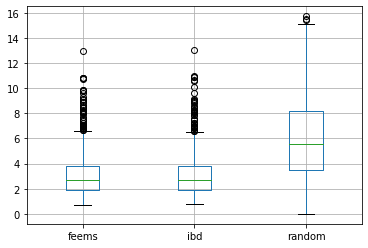

In [191]:
loo_results = leave_node_out(genotypes[:, :100], coord, grid, edges)
loo_results = pd.DataFrame(loo_results).T.rename(
    columns = {0:'feems', 1:'ibd', 2:'random'}
)
loo_results100 = loo_results.apply(lambda x: x.explode())

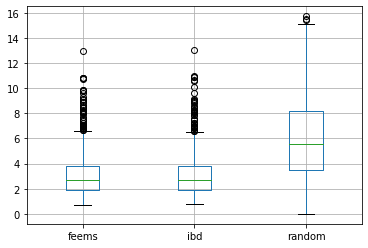

In [195]:
(loo_results100.reset_index().drop(columns='index')).fillna(10).boxplot()

In [198]:
loo_results = leave_node_out(genotypes[:, :500], coord, grid, edges)
loo_results = pd.DataFrame(loo_results).T.rename(
    columns = {0:'feems', 1:'ibd', 2:'random'}
)
loo_results500 = loo_results.apply(lambda x: x.explode())

0it [00:00, ?it/s]

constant-w/variance fit, converged in 111 iterations, train_loss=-4873.9766850


1it [00:02,  2.01s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-4873.9766850
lambda=1.0000000, alpha=0.4657140, converged in 17 iterations, train_loss=-6396.5640297
constant-w/variance fit, converged in 123 iterations, train_loss=-4855.0683248


2it [00:04,  2.07s/it]

constant-w/variance fit, converged in 123 iterations, train_loss=-4855.0683248
lambda=1.0000000, alpha=0.4610569, converged in 15 iterations, train_loss=-6391.4490384
constant-w/variance fit, converged in 113 iterations, train_loss=-4686.6135328


3it [00:06,  2.06s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-4686.6135328
lambda=1.0000000, alpha=0.4658615, converged in 15 iterations, train_loss=-6218.6459880
constant-w/variance fit, converged in 109 iterations, train_loss=-4597.0305196


4it [00:08,  2.05s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-4597.0305196
lambda=1.0000000, alpha=0.4682450, converged in 14 iterations, train_loss=-6107.3559591
constant-w/variance fit, converged in 106 iterations, train_loss=-4715.5649231


5it [00:10,  2.03s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-4715.5649231
lambda=1.0000000, alpha=0.4631201, converged in 15 iterations, train_loss=-6251.1728495
constant-w/variance fit, converged in 116 iterations, train_loss=-4748.3501554


6it [00:12,  2.03s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4748.3501554
lambda=1.0000000, alpha=0.4646458, converged in 14 iterations, train_loss=-6285.4482806
constant-w/variance fit, converged in 117 iterations, train_loss=-4900.9088628


7it [00:14,  2.05s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4900.9088628
lambda=1.0000000, alpha=0.4601492, converged in 16 iterations, train_loss=-6465.1166143
constant-w/variance fit, converged in 105 iterations, train_loss=-4646.1408385


8it [00:16,  2.05s/it]

constant-w/variance fit, converged in 105 iterations, train_loss=-4646.1408385
lambda=1.0000000, alpha=0.4684276, converged in 15 iterations, train_loss=-6193.4980383
constant-w/variance fit, converged in 115 iterations, train_loss=-4911.4983069


9it [00:18,  2.08s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4911.4983069
lambda=1.0000000, alpha=0.4606400, converged in 15 iterations, train_loss=-6472.6659926
constant-w/variance fit, converged in 118 iterations, train_loss=-4738.6954397


10it [00:20,  2.15s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4738.6954397
lambda=1.0000000, alpha=0.4636222, converged in 15 iterations, train_loss=-6283.2108585
constant-w/variance fit, converged in 120 iterations, train_loss=-4852.5843503


11it [00:23,  2.16s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4852.5843503
lambda=1.0000000, alpha=0.4625128, converged in 15 iterations, train_loss=-6407.8245480
constant-w/variance fit, converged in 112 iterations, train_loss=-4725.1829045


12it [00:25,  2.15s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-4725.1829045
lambda=1.0000000, alpha=0.4654790, converged in 15 iterations, train_loss=-6268.3770060
constant-w/variance fit, converged in 107 iterations, train_loss=-4708.6180156


13it [00:27,  2.12s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-4708.6180156
lambda=1.0000000, alpha=0.4638167, converged in 14 iterations, train_loss=-6229.3542124
constant-w/variance fit, converged in 122 iterations, train_loss=-4825.7179333


14it [00:29,  2.18s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-4825.7179333
lambda=1.0000000, alpha=0.4636541, converged in 14 iterations, train_loss=-6362.2906030
constant-w/variance fit, converged in 121 iterations, train_loss=-4830.5961562


15it [00:31,  2.23s/it]

constant-w/variance fit, converged in 121 iterations, train_loss=-4830.5961562
lambda=1.0000000, alpha=0.4637251, converged in 15 iterations, train_loss=-6381.7172164
constant-w/variance fit, converged in 114 iterations, train_loss=-4860.4047501


16it [00:34,  2.21s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4860.4047501
lambda=1.0000000, alpha=0.4668007, converged in 15 iterations, train_loss=-6423.8306497
constant-w/variance fit, converged in 117 iterations, train_loss=-4779.6767438


17it [00:36,  2.21s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4779.6767438
lambda=1.0000000, alpha=0.4654148, converged in 17 iterations, train_loss=-6339.4331514
constant-w/variance fit, converged in 115 iterations, train_loss=-4671.8531576


18it [00:38,  2.20s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4671.8531576
lambda=1.0000000, alpha=0.4655013, converged in 15 iterations, train_loss=-6222.5968794
constant-w/variance fit, converged in 122 iterations, train_loss=-4675.1879008


19it [00:40,  2.19s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-4675.1879008
lambda=1.0000000, alpha=0.4638569, converged in 14 iterations, train_loss=-6223.9073281
constant-w/variance fit, converged in 118 iterations, train_loss=-4750.4313173


20it [00:42,  2.17s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4750.4313173
lambda=1.0000000, alpha=0.4650908, converged in 14 iterations, train_loss=-6312.5600378
constant-w/variance fit, converged in 120 iterations, train_loss=-4639.5861651


21it [00:44,  2.15s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4639.5861651
lambda=1.0000000, alpha=0.4644142, converged in 16 iterations, train_loss=-6184.1147144
constant-w/variance fit, converged in 116 iterations, train_loss=-4763.5188467


22it [00:46,  2.13s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4763.5188467
lambda=1.0000000, alpha=0.4645784, converged in 15 iterations, train_loss=-6319.6194003
constant-w/variance fit, converged in 116 iterations, train_loss=-4629.0371529


23it [00:48,  2.11s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4629.0371529
lambda=1.0000000, alpha=0.4643616, converged in 15 iterations, train_loss=-6170.6940842
constant-w/variance fit, converged in 114 iterations, train_loss=-4675.6316369


24it [00:51,  2.11s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4675.6316369
lambda=1.0000000, alpha=0.4652779, converged in 15 iterations, train_loss=-6224.2108152
constant-w/variance fit, converged in 117 iterations, train_loss=-4697.3563425


25it [00:53,  2.18s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4697.3563425
lambda=1.0000000, alpha=0.4657734, converged in 15 iterations, train_loss=-6244.1445048
constant-w/variance fit, converged in 118 iterations, train_loss=-4638.8680268


26it [00:55,  2.19s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4638.8680268
lambda=1.0000000, alpha=0.4640325, converged in 15 iterations, train_loss=-6182.4913847
constant-w/variance fit, converged in 114 iterations, train_loss=-4619.3364585


27it [00:57,  2.17s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4619.3364585
lambda=1.0000000, alpha=0.4650400, converged in 15 iterations, train_loss=-6170.0392134
constant-w/variance fit, converged in 120 iterations, train_loss=-4781.7124403


28it [00:59,  2.19s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4781.7124403
lambda=1.0000000, alpha=0.4634786, converged in 15 iterations, train_loss=-6341.1401763
constant-w/variance fit, converged in 119 iterations, train_loss=-4912.9571476


29it [01:02,  2.19s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4912.9571476
lambda=1.0000000, alpha=0.4668844, converged in 15 iterations, train_loss=-6467.9338242
constant-w/variance fit, converged in 116 iterations, train_loss=-4804.1707717


30it [01:04,  2.17s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4804.1707717
lambda=1.0000000, alpha=0.4641756, converged in 15 iterations, train_loss=-6354.2077849
constant-w/variance fit, converged in 119 iterations, train_loss=-4697.7986511


31it [01:06,  2.16s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4697.7986511
lambda=1.0000000, alpha=0.4637009, converged in 15 iterations, train_loss=-6241.3406723
constant-w/variance fit, converged in 115 iterations, train_loss=-4973.7421839


32it [01:08,  2.15s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4973.7421839
lambda=1.0000000, alpha=0.4607365, converged in 16 iterations, train_loss=-6506.6828499
constant-w/variance fit, converged in 110 iterations, train_loss=-4757.2626701


33it [01:10,  2.13s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-4757.2626701
lambda=1.0000000, alpha=0.4686985, converged in 17 iterations, train_loss=-6321.9762362
constant-w/variance fit, converged in 117 iterations, train_loss=-4706.5660486


34it [01:12,  2.12s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4706.5660486
lambda=1.0000000, alpha=0.4628394, converged in 14 iterations, train_loss=-6249.7495230
constant-w/variance fit, converged in 109 iterations, train_loss=-4560.7357420


35it [01:14,  2.10s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-4560.7357420
lambda=1.0000000, alpha=0.4654274, converged in 14 iterations, train_loss=-6101.5036096
constant-w/variance fit, converged in 118 iterations, train_loss=-4684.5232232


36it [01:16,  2.10s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4684.5232232
lambda=1.0000000, alpha=0.4646930, converged in 14 iterations, train_loss=-6235.6281240
constant-w/variance fit, converged in 118 iterations, train_loss=-4695.1809445


37it [01:19,  2.12s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4695.1809445
lambda=1.0000000, alpha=0.4635051, converged in 15 iterations, train_loss=-6237.4375455
constant-w/variance fit, converged in 121 iterations, train_loss=-4656.7461610


38it [01:21,  2.12s/it]

constant-w/variance fit, converged in 121 iterations, train_loss=-4656.7461610
lambda=1.0000000, alpha=0.4621184, converged in 14 iterations, train_loss=-6195.1125641
constant-w/variance fit, converged in 116 iterations, train_loss=-4663.7327839


39it [01:23,  2.11s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4663.7327839
lambda=1.0000000, alpha=0.4647081, converged in 15 iterations, train_loss=-6217.8396182
constant-w/variance fit, converged in 116 iterations, train_loss=-4889.1266817


40it [01:25,  2.11s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4889.1266817
lambda=1.0000000, alpha=0.4654372, converged in 15 iterations, train_loss=-6450.6516567
constant-w/variance fit, converged in 121 iterations, train_loss=-4601.3950443


41it [01:27,  2.12s/it]

constant-w/variance fit, converged in 121 iterations, train_loss=-4601.3950443
lambda=1.0000000, alpha=0.4647896, converged in 15 iterations, train_loss=-6158.6986157
constant-w/variance fit, converged in 115 iterations, train_loss=-4895.9387840


42it [01:29,  2.12s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4895.9387840
lambda=1.0000000, alpha=0.4641002, converged in 15 iterations, train_loss=-6452.6333562
constant-w/variance fit, converged in 118 iterations, train_loss=-4605.2316278


43it [01:31,  2.12s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4605.2316278
lambda=1.0000000, alpha=0.4623606, converged in 15 iterations, train_loss=-6154.7901359
constant-w/variance fit, converged in 118 iterations, train_loss=-4793.0644751


44it [01:34,  2.18s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4793.0644751
lambda=1.0000000, alpha=0.4646427, converged in 15 iterations, train_loss=-6349.0604032
constant-w/variance fit, converged in 116 iterations, train_loss=-4617.3490431


45it [01:36,  2.21s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4617.3490431
lambda=1.0000000, alpha=0.4639790, converged in 15 iterations, train_loss=-6166.3099758
constant-w/variance fit, converged in 118 iterations, train_loss=-4752.7063765


46it [01:38,  2.23s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4752.7063765
lambda=1.0000000, alpha=0.4650052, converged in 15 iterations, train_loss=-6307.2209465
constant-w/variance fit, converged in 107 iterations, train_loss=-4552.4635601


47it [01:40,  2.21s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-4552.4635601
lambda=1.0000000, alpha=0.4638980, converged in 14 iterations, train_loss=-6087.8113517
constant-w/variance fit, converged in 119 iterations, train_loss=-4854.5421726


48it [01:43,  2.24s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4854.5421726
lambda=1.0000000, alpha=0.4660116, converged in 16 iterations, train_loss=-6400.3640826
constant-w/variance fit, converged in 108 iterations, train_loss=-5285.4905999


49it [01:45,  2.20s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-5285.4905999
lambda=1.0000000, alpha=0.4657659, converged in 14 iterations, train_loss=-6764.4954655
constant-w/variance fit, converged in 114 iterations, train_loss=-4797.4768052


50it [01:47,  2.17s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4797.4768052
lambda=1.0000000, alpha=0.4629970, converged in 14 iterations, train_loss=-6353.6858120
constant-w/variance fit, converged in 119 iterations, train_loss=-4806.1557139


51it [01:49,  2.16s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4806.1557139
lambda=1.0000000, alpha=0.4630571, converged in 15 iterations, train_loss=-6364.4958964
constant-w/variance fit, converged in 117 iterations, train_loss=-4802.1818192


52it [01:51,  2.16s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4802.1818192
lambda=1.0000000, alpha=0.4640042, converged in 15 iterations, train_loss=-6358.1366209
constant-w/variance fit, converged in 118 iterations, train_loss=-4743.8018359


53it [01:53,  2.18s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4743.8018359
lambda=1.0000000, alpha=0.4657928, converged in 15 iterations, train_loss=-6304.7561698
constant-w/variance fit, converged in 121 iterations, train_loss=-4612.4984593


54it [01:56,  2.18s/it]

constant-w/variance fit, converged in 121 iterations, train_loss=-4612.4984593
lambda=1.0000000, alpha=0.4629158, converged in 15 iterations, train_loss=-6172.9750699
constant-w/variance fit, converged in 112 iterations, train_loss=-5145.6950434


55it [01:58,  2.14s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-5145.6950434
lambda=1.0000000, alpha=0.4633733, converged in 15 iterations, train_loss=-6672.4587605
constant-w/variance fit, converged in 115 iterations, train_loss=-4677.8431614


56it [02:00,  2.13s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4677.8431614
lambda=1.0000000, alpha=0.4648451, converged in 15 iterations, train_loss=-6244.5562313
constant-w/variance fit, converged in 119 iterations, train_loss=-4785.2981833


57it [02:02,  2.14s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4785.2981833
lambda=1.0000000, alpha=0.4659773, converged in 15 iterations, train_loss=-6349.9834217
constant-w/variance fit, converged in 116 iterations, train_loss=-4837.9507609


58it [02:04,  2.13s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4837.9507609
lambda=1.0000000, alpha=0.4641263, converged in 15 iterations, train_loss=-6389.7383519


59it [02:06,  2.24s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4675.7497451


60it [02:08,  2.19s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4675.7497451
lambda=1.0000000, alpha=0.4626037, converged in 15 iterations, train_loss=-6226.6053944
constant-w/variance fit, converged in 118 iterations, train_loss=-4661.4387771


61it [02:11,  2.16s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4661.4387771
lambda=1.0000000, alpha=0.4625127, converged in 15 iterations, train_loss=-6206.8210158
constant-w/variance fit, converged in 107 iterations, train_loss=-4591.4631940


62it [02:13,  2.11s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-4591.4631940
lambda=1.0000000, alpha=0.4634631, converged in 15 iterations, train_loss=-6132.8038439
constant-w/variance fit, converged in 116 iterations, train_loss=-4714.3375321


63it [02:15,  2.12s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4714.3375321
lambda=1.0000000, alpha=0.4627214, converged in 14 iterations, train_loss=-6249.3088852
constant-w/variance fit, converged in 111 iterations, train_loss=-4827.1834340


64it [02:17,  2.10s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-4827.1834340
lambda=1.0000000, alpha=0.4665346, converged in 16 iterations, train_loss=-6385.0859432
constant-w/variance fit, converged in 110 iterations, train_loss=-4802.6427519


65it [02:19,  2.11s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-4802.6427519
lambda=1.0000000, alpha=0.4666271, converged in 16 iterations, train_loss=-6354.6734451
constant-w/variance fit, converged in 119 iterations, train_loss=-4753.9749829


66it [02:21,  2.14s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4753.9749829
lambda=1.0000000, alpha=0.4622553, converged in 14 iterations, train_loss=-6289.2382855
constant-w/variance fit, converged in 120 iterations, train_loss=-4660.2050213


67it [02:23,  2.12s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4660.2050213
lambda=1.0000000, alpha=0.4637317, converged in 15 iterations, train_loss=-6200.9536777
constant-w/variance fit, converged in 120 iterations, train_loss=-4607.6288227


68it [02:25,  2.10s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4607.6288227
lambda=1.0000000, alpha=0.4626227, converged in 15 iterations, train_loss=-6145.0716844
constant-w/variance fit, converged in 116 iterations, train_loss=-4617.5296594


69it [02:28,  2.19s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4617.5296594
lambda=1.0000000, alpha=0.4641297, converged in 15 iterations, train_loss=-6163.4531759
constant-w/variance fit, converged in 104 iterations, train_loss=-4584.2745231


70it [02:30,  2.26s/it]

constant-w/variance fit, converged in 104 iterations, train_loss=-4584.2745231
lambda=1.0000000, alpha=0.4640220, converged in 15 iterations, train_loss=-6126.3773031
constant-w/variance fit, converged in 123 iterations, train_loss=-4772.3910406


71it [02:32,  2.30s/it]

constant-w/variance fit, converged in 123 iterations, train_loss=-4772.3910406
lambda=1.0000000, alpha=0.4646245, converged in 15 iterations, train_loss=-6332.7364052
constant-w/variance fit, converged in 116 iterations, train_loss=-4623.9618667


72it [02:35,  2.27s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4623.9618667
lambda=1.0000000, alpha=0.4643238, converged in 15 iterations, train_loss=-6177.5651510
constant-w/variance fit, converged in 106 iterations, train_loss=-4548.2740132


73it [02:37,  2.22s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-4548.2740132
lambda=1.0000000, alpha=0.4653821, converged in 15 iterations, train_loss=-6099.4864151
constant-w/variance fit, converged in 119 iterations, train_loss=-4821.4077916


74it [02:39,  2.20s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4821.4077916
lambda=1.0000000, alpha=0.4661444, converged in 15 iterations, train_loss=-6387.1099122
constant-w/variance fit, converged in 245 iterations, train_loss=-4962.3891957


75it [02:42,  2.43s/it]

constant-w/variance fit, converged in 245 iterations, train_loss=-4962.3891957
lambda=1.0000000, alpha=0.4646734, converged in 15 iterations, train_loss=-6513.9830159
constant-w/variance fit, converged in 108 iterations, train_loss=-4594.4658759


76it [02:44,  2.33s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-4594.4658759
lambda=1.0000000, alpha=0.4659531, converged in 15 iterations, train_loss=-6158.1788146
constant-w/variance fit, converged in 118 iterations, train_loss=-4592.7741888


77it [02:46,  2.27s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4592.7741888
lambda=1.0000000, alpha=0.4633601, converged in 15 iterations, train_loss=-6131.9814745
constant-w/variance fit, converged in 115 iterations, train_loss=-4622.9357403


78it [02:48,  2.21s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4622.9357403
lambda=1.0000000, alpha=0.4650764, converged in 15 iterations, train_loss=-6172.8363185


79it [02:51,  2.31s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4686.8052978


80it [02:53,  2.26s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4686.8052978
lambda=1.0000000, alpha=0.4674152, converged in 16 iterations, train_loss=-6264.4909085
constant-w/variance fit, converged in 122 iterations, train_loss=-4665.8181477


81it [02:55,  2.23s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-4665.8181477
lambda=1.0000000, alpha=0.4635500, converged in 15 iterations, train_loss=-6214.7608888
constant-w/variance fit, converged in 116 iterations, train_loss=-4673.7393341


82it [02:57,  2.19s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4673.7393341
lambda=1.0000000, alpha=0.4646913, converged in 15 iterations, train_loss=-6233.3598583
constant-w/variance fit, converged in 122 iterations, train_loss=-4755.4592068


83it [02:59,  2.18s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-4755.4592068
lambda=1.0000000, alpha=0.4625253, converged in 15 iterations, train_loss=-6303.3797500
constant-w/variance fit, converged in 116 iterations, train_loss=-4649.9235530


84it [03:01,  2.15s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4649.9235530
lambda=1.0000000, alpha=0.4644288, converged in 16 iterations, train_loss=-6195.0927637
constant-w/variance fit, converged in 118 iterations, train_loss=-4653.4182807


85it [03:03,  2.15s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4653.4182807
lambda=1.0000000, alpha=0.4636546, converged in 15 iterations, train_loss=-6199.5414896
constant-w/variance fit, converged in 118 iterations, train_loss=-4633.4446798


86it [03:06,  2.14s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4633.4446798
lambda=1.0000000, alpha=0.4643646, converged in 15 iterations, train_loss=-6180.3267404
constant-w/variance fit, converged in 117 iterations, train_loss=-4673.2407124


87it [03:08,  2.12s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4673.2407124
lambda=1.0000000, alpha=0.4640216, converged in 15 iterations, train_loss=-6228.7873246


88it [03:10,  2.27s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4761.4819815


89it [03:12,  2.22s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4761.4819815
lambda=1.0000000, alpha=0.4622859, converged in 15 iterations, train_loss=-6315.9079485
constant-w/variance fit, converged in 111 iterations, train_loss=-4536.1981530


90it [03:14,  2.18s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-4536.1981530
lambda=1.0000000, alpha=0.4645064, converged in 15 iterations, train_loss=-6095.1742859


91it [03:17,  2.34s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4783.9167140


92it [03:19,  2.32s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4783.9167140
lambda=1.0000000, alpha=0.4632830, converged in 15 iterations, train_loss=-6338.0139941
constant-w/variance fit, converged in 119 iterations, train_loss=-4741.5379947


93it [03:22,  2.30s/it]

constant-w/variance fit, converged in 119 iterations, train_loss=-4741.5379947
lambda=1.0000000, alpha=0.4632888, converged in 15 iterations, train_loss=-6299.2527509


94it [03:24,  2.39s/it]

constant-w/variance fit, converged in 192 iterations, train_loss=-4947.0119809


95it [03:27,  2.48s/it]

constant-w/variance fit, converged in 192 iterations, train_loss=-4947.0119809
lambda=1.0000000, alpha=0.4625957, converged in 15 iterations, train_loss=-6482.0135823
constant-w/variance fit, converged in 142 iterations, train_loss=-5144.2563735


96it [03:30,  2.52s/it]

constant-w/variance fit, converged in 142 iterations, train_loss=-5144.2563735
lambda=1.0000000, alpha=0.4560741, converged in 16 iterations, train_loss=-6647.2855584
constant-w/variance fit, converged in 114 iterations, train_loss=-4728.4322338


97it [03:32,  2.40s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4728.4322338
lambda=1.0000000, alpha=0.4703261, converged in 16 iterations, train_loss=-6281.3038945
constant-w/variance fit, converged in 117 iterations, train_loss=-4772.1170600


98it [03:34,  2.32s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4772.1170600
lambda=1.0000000, alpha=0.4614968, converged in 15 iterations, train_loss=-6326.0241208
constant-w/variance fit, converged in 114 iterations, train_loss=-4897.9656500


99it [03:36,  2.23s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4897.9656500
lambda=1.0000000, alpha=0.4648027, converged in 15 iterations, train_loss=-6447.8213755
constant-w/variance fit, converged in 115 iterations, train_loss=-4690.1772918


100it [03:38,  2.20s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4690.1772918
lambda=1.0000000, alpha=0.4643577, converged in 16 iterations, train_loss=-6249.7579635
constant-w/variance fit, converged in 113 iterations, train_loss=-4894.8224936


101it [03:40,  2.18s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-4894.8224936
lambda=1.0000000, alpha=0.4652259, converged in 14 iterations, train_loss=-6473.8972311
constant-w/variance fit, converged in 115 iterations, train_loss=-4643.8549542


102it [03:42,  2.15s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4643.8549542
lambda=1.0000000, alpha=0.4669556, converged in 14 iterations, train_loss=-6196.7203484
constant-w/variance fit, converged in 120 iterations, train_loss=-4665.5365008


103it [03:44,  2.16s/it]

constant-w/variance fit, converged in 120 iterations, train_loss=-4665.5365008
lambda=1.0000000, alpha=0.4655395, converged in 15 iterations, train_loss=-6216.6952031
constant-w/variance fit, converged in 116 iterations, train_loss=-4644.7824525


104it [03:47,  2.23s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4644.7824525
lambda=1.0000000, alpha=0.4650182, converged in 15 iterations, train_loss=-6195.5507260
constant-w/variance fit, converged in 117 iterations, train_loss=-4809.2812108


105it [03:49,  2.22s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4809.2812108
lambda=1.0000000, alpha=0.4650698, converged in 15 iterations, train_loss=-6368.5854377
constant-w/variance fit, converged in 114 iterations, train_loss=-4661.4600854


106it [03:51,  2.20s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4661.4600854
lambda=1.0000000, alpha=0.4662363, converged in 15 iterations, train_loss=-6221.4322684
constant-w/variance fit, converged in 118 iterations, train_loss=-4829.6141627


107it [03:53,  2.19s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4829.6141627
lambda=1.0000000, alpha=0.4643413, converged in 15 iterations, train_loss=-6390.7771027
constant-w/variance fit, converged in 114 iterations, train_loss=-4803.1558087


108it [03:55,  2.18s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-4803.1558087
lambda=1.0000000, alpha=0.4655917, converged in 16 iterations, train_loss=-6357.7959751


109it [03:58,  2.29s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4654.1331315


110it [04:00,  2.26s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4654.1331315
lambda=1.0000000, alpha=0.4646755, converged in 15 iterations, train_loss=-6199.1523440
constant-w/variance fit, converged in 118 iterations, train_loss=-4657.3667367


111it [04:02,  2.22s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4657.3667367
lambda=1.0000000, alpha=0.4641382, converged in 15 iterations, train_loss=-6201.9286683
constant-w/variance fit, converged in 116 iterations, train_loss=-4934.3741535


112it [04:04,  2.18s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4934.3741535
lambda=1.0000000, alpha=0.4669790, converged in 14 iterations, train_loss=-6477.6176802
constant-w/variance fit, converged in 106 iterations, train_loss=-4785.6760858


113it [04:06,  2.14s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-4785.6760858
lambda=1.0000000, alpha=0.4672104, converged in 14 iterations, train_loss=-6317.8451019
constant-w/variance fit, converged in 118 iterations, train_loss=-4788.2947874


114it [04:09,  2.14s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4788.2947874
lambda=1.0000000, alpha=0.4640372, converged in 15 iterations, train_loss=-6318.4411383
constant-w/variance fit, converged in 126 iterations, train_loss=-4803.5096211


115it [04:11,  2.17s/it]

constant-w/variance fit, converged in 126 iterations, train_loss=-4803.5096211
lambda=1.0000000, alpha=0.4631608, converged in 15 iterations, train_loss=-6336.4424482
constant-w/variance fit, converged in 113 iterations, train_loss=-4600.0626121


116it [04:13,  2.14s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-4600.0626121
lambda=1.0000000, alpha=0.4661622, converged in 15 iterations, train_loss=-6120.4575920
constant-w/variance fit, converged in 106 iterations, train_loss=-4678.6348181


117it [04:15,  2.12s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-4678.6348181
lambda=1.0000000, alpha=0.4669919, converged in 15 iterations, train_loss=-6220.9580297
constant-w/variance fit, converged in 117 iterations, train_loss=-4829.4903513


118it [04:17,  2.12s/it]

constant-w/variance fit, converged in 117 iterations, train_loss=-4829.4903513
lambda=1.0000000, alpha=0.4627235, converged in 15 iterations, train_loss=-6395.7266835
constant-w/variance fit, converged in 115 iterations, train_loss=-4730.1186380


119it [04:19,  2.14s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4730.1186380
lambda=1.0000000, alpha=0.4651024, converged in 15 iterations, train_loss=-6279.7353119
constant-w/variance fit, converged in 116 iterations, train_loss=-5026.7136950


120it [04:21,  2.13s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-5026.7136950
lambda=1.0000000, alpha=0.4667201, converged in 15 iterations, train_loss=-6592.4176140
constant-w/variance fit, converged in 118 iterations, train_loss=-4873.4122404


121it [04:24,  2.13s/it]

constant-w/variance fit, converged in 118 iterations, train_loss=-4873.4122404
lambda=1.0000000, alpha=0.4647622, converged in 15 iterations, train_loss=-6432.8229096
constant-w/variance fit, converged in 115 iterations, train_loss=-4898.9841227


122it [04:26,  2.12s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-4898.9841227
lambda=1.0000000, alpha=0.4641409, converged in 15 iterations, train_loss=-6461.7896197
constant-w/variance fit, converged in 110 iterations, train_loss=-4638.0701927


123it [04:28,  2.10s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-4638.0701927
lambda=1.0000000, alpha=0.4675776, converged in 14 iterations, train_loss=-6181.1019171
constant-w/variance fit, converged in 122 iterations, train_loss=-4909.4421470


124it [04:30,  2.12s/it]

constant-w/variance fit, converged in 122 iterations, train_loss=-4909.4421470
lambda=1.0000000, alpha=0.4624276, converged in 14 iterations, train_loss=-6457.8593970
constant-w/variance fit, converged in 116 iterations, train_loss=-4753.0028280


125it [04:32,  2.11s/it]

constant-w/variance fit, converged in 116 iterations, train_loss=-4753.0028280
lambda=1.0000000, alpha=0.4651969, converged in 15 iterations, train_loss=-6289.2603037
constant-w/variance fit, converged in 109 iterations, train_loss=-4721.2081371


126it [04:34,  2.09s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-4721.2081371
lambda=1.0000000, alpha=0.4646872, converged in 15 iterations, train_loss=-6258.5164051
constant-w/variance fit, converged in 121 iterations, train_loss=-4800.3408282


127it [04:36,  2.11s/it]

constant-w/variance fit, converged in 121 iterations, train_loss=-4800.3408282
lambda=1.0000000, alpha=0.4640361, converged in 14 iterations, train_loss=-6322.0378900
constant-w/variance fit, converged in 112 iterations, train_loss=-4851.1946130


128it [04:38,  2.18s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-4851.1946130
lambda=1.0000000, alpha=0.4665558, converged in 17 iterations, train_loss=-6374.8223598


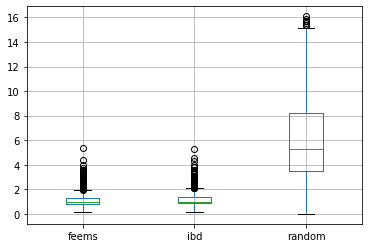

In [199]:
(loo_results500.reset_index().drop(columns='index')).fillna(10).boxplot()

In [200]:
loo_results = leave_node_out(genotypes[:, :1000], coord, grid, edges)
loo_results = pd.DataFrame(loo_results).T.rename(
    columns = {0:'feems', 1:'ibd', 2:'random'})
loo_results1000 = loo_results.apply(lambda x: x.explode())

1it [00:02,  2.64s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10624.9422333


2it [00:04,  2.36s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10624.9422333
lambda=1.0000000, alpha=0.4551505, converged in 16 iterations, train_loss=-13744.5373931
constant-w/variance fit, converged in 112 iterations, train_loss=-10561.8683525


3it [00:06,  2.26s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10561.8683525
lambda=1.0000000, alpha=0.4581113, converged in 17 iterations, train_loss=-13700.7948048


5it [00:12,  2.47s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10495.6273223


6it [00:14,  2.41s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10495.6273223
lambda=1.0000000, alpha=0.4570981, converged in 15 iterations, train_loss=-13632.2851865
constant-w/variance fit, converged in 111 iterations, train_loss=-10605.0249759


7it [00:16,  2.39s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10605.0249759
lambda=1.0000000, alpha=0.4550217, converged in 15 iterations, train_loss=-13783.8117811


8it [00:19,  2.50s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10848.0901135


9it [00:21,  2.48s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10848.0901135
lambda=1.0000000, alpha=0.4541993, converged in 15 iterations, train_loss=-14065.4734543


10it [00:24,  2.50s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-10485.7176090


11it [00:26,  2.38s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-10485.7176090
lambda=1.0000000, alpha=0.4552648, converged in 15 iterations, train_loss=-13647.2754186


13it [00:31,  2.48s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10425.9322170


14it [00:33,  2.35s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10425.9322170
lambda=1.0000000, alpha=0.4571453, converged in 17 iterations, train_loss=-13572.0580674
constant-w/variance fit, converged in 111 iterations, train_loss=-10700.9126614


15it [00:35,  2.25s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10700.9126614
lambda=1.0000000, alpha=0.4549803, converged in 17 iterations, train_loss=-13851.2403594
constant-w/variance fit, converged in 112 iterations, train_loss=-10987.4059115


16it [00:37,  2.18s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10987.4059115
lambda=1.0000000, alpha=0.4524117, converged in 17 iterations, train_loss=-14109.6483735
constant-w/variance fit, converged in 108 iterations, train_loss=-10399.7990908


17it [00:39,  2.13s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10399.7990908
lambda=1.0000000, alpha=0.4584295, converged in 19 iterations, train_loss=-13601.4609144
constant-w/variance fit, converged in 111 iterations, train_loss=-10854.3190860


18it [00:41,  2.12s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10854.3190860
lambda=1.0000000, alpha=0.4582722, converged in 16 iterations, train_loss=-13988.9045310
constant-w/variance fit, converged in 110 iterations, train_loss=-10356.5857967


19it [00:43,  2.10s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10356.5857967
lambda=1.0000000, alpha=0.4564629, converged in 15 iterations, train_loss=-13522.0407738
constant-w/variance fit, converged in 108 iterations, train_loss=-10392.3998221


20it [00:46,  2.11s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10392.3998221
lambda=1.0000000, alpha=0.4572336, converged in 15 iterations, train_loss=-13570.4493956
constant-w/variance fit, converged in 110 iterations, train_loss=-10332.1268666


21it [00:48,  2.11s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10332.1268666
lambda=1.0000000, alpha=0.4580843, converged in 16 iterations, train_loss=-13502.3863788
constant-w/variance fit, converged in 112 iterations, train_loss=-10448.8893644


22it [00:50,  2.14s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10448.8893644
lambda=1.0000000, alpha=0.4575710, converged in 15 iterations, train_loss=-13613.7942933
constant-w/variance fit, converged in 108 iterations, train_loss=-10172.8954749


23it [00:52,  2.15s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10172.8954749
lambda=1.0000000, alpha=0.4566800, converged in 15 iterations, train_loss=-13307.4607725
constant-w/variance fit, converged in 109 iterations, train_loss=-10226.8271545


24it [00:54,  2.17s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10226.8271545
lambda=1.0000000, alpha=0.4576166, converged in 15 iterations, train_loss=-13364.2918193
constant-w/variance fit, converged in 112 iterations, train_loss=-10162.9554812


25it [00:56,  2.14s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10162.9554812
lambda=1.0000000, alpha=0.4573537, converged in 15 iterations, train_loss=-13292.1265819
constant-w/variance fit, converged in 110 iterations, train_loss=-10157.5996725


26it [00:59,  2.14s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10157.5996725
lambda=1.0000000, alpha=0.4564553, converged in 15 iterations, train_loss=-13296.5696126
constant-w/variance fit, converged in 113 iterations, train_loss=-10269.0305410


27it [01:01,  2.24s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10269.0305410
lambda=1.0000000, alpha=0.4572234, converged in 15 iterations, train_loss=-13427.1639577
constant-w/variance fit, converged in 113 iterations, train_loss=-10244.2520599


28it [01:03,  2.30s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10244.2520599
lambda=1.0000000, alpha=0.4557881, converged in 15 iterations, train_loss=-13400.9189774
constant-w/variance fit, converged in 111 iterations, train_loss=-10403.8194182


29it [01:06,  2.33s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10403.8194182
lambda=1.0000000, alpha=0.4568353, converged in 15 iterations, train_loss=-13574.0414835
constant-w/variance fit, converged in 108 iterations, train_loss=-10528.7099118


30it [01:08,  2.24s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10528.7099118
lambda=1.0000000, alpha=0.4564517, converged in 15 iterations, train_loss=-13702.2726977
constant-w/variance fit, converged in 114 iterations, train_loss=-10396.6004648


31it [01:10,  2.20s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-10396.6004648
lambda=1.0000000, alpha=0.4571341, converged in 17 iterations, train_loss=-13532.9070303
constant-w/variance fit, converged in 107 iterations, train_loss=-10613.5645453


32it [01:12,  2.14s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10613.5645453
lambda=1.0000000, alpha=0.4570366, converged in 18 iterations, train_loss=-13788.7050419


33it [01:14,  2.23s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10209.9259422


34it [01:17,  2.18s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10209.9259422
lambda=1.0000000, alpha=0.4552545, converged in 16 iterations, train_loss=-13333.8974222
constant-w/variance fit, converged in 109 iterations, train_loss=-10350.6834369


35it [01:18,  2.12s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10350.6834369
lambda=1.0000000, alpha=0.4570284, converged in 16 iterations, train_loss=-13508.3845126
constant-w/variance fit, converged in 107 iterations, train_loss=-10369.3241546


36it [01:21,  2.20s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10369.3241546
lambda=1.0000000, alpha=0.4574829, converged in 15 iterations, train_loss=-13538.8674693
constant-w/variance fit, converged in 109 iterations, train_loss=-10493.8786451


37it [01:23,  2.18s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10493.8786451
lambda=1.0000000, alpha=0.4566111, converged in 15 iterations, train_loss=-13653.6707408
constant-w/variance fit, converged in 112 iterations, train_loss=-10571.6750027


38it [01:25,  2.16s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10571.6750027
lambda=1.0000000, alpha=0.4563069, converged in 15 iterations, train_loss=-13727.9930661
constant-w/variance fit, converged in 114 iterations, train_loss=-10370.4541590


39it [01:27,  2.18s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-10370.4541590
lambda=1.0000000, alpha=0.4563288, converged in 15 iterations, train_loss=-13539.9021971
constant-w/variance fit, converged in 106 iterations, train_loss=-10566.8590641


40it [01:30,  2.17s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-10566.8590641
lambda=1.0000000, alpha=0.4568401, converged in 15 iterations, train_loss=-13741.7845440
constant-w/variance fit, converged in 112 iterations, train_loss=-10252.4184064


41it [01:32,  2.16s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10252.4184064
lambda=1.0000000, alpha=0.4565067, converged in 15 iterations, train_loss=-13419.5033180
constant-w/variance fit, converged in 111 iterations, train_loss=-10526.2793135


42it [01:34,  2.19s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10526.2793135
lambda=1.0000000, alpha=0.4558078, converged in 15 iterations, train_loss=-13707.6678275
constant-w/variance fit, converged in 108 iterations, train_loss=-10194.6060897


43it [01:36,  2.16s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10194.6060897
lambda=1.0000000, alpha=0.4552758, converged in 16 iterations, train_loss=-13357.4479833
constant-w/variance fit, converged in 114 iterations, train_loss=-10487.9881165


44it [01:38,  2.15s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-10487.9881165
lambda=1.0000000, alpha=0.4568961, converged in 15 iterations, train_loss=-13662.5038480
constant-w/variance fit, converged in 107 iterations, train_loss=-10166.1367406


45it [01:40,  2.11s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10166.1367406
lambda=1.0000000, alpha=0.4565412, converged in 15 iterations, train_loss=-13326.2160371
constant-w/variance fit, converged in 109 iterations, train_loss=-10443.9557799


46it [01:42,  2.11s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10443.9557799
lambda=1.0000000, alpha=0.4569151, converged in 15 iterations, train_loss=-13612.2030419


47it [01:45,  2.22s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10541.4453843


48it [01:47,  2.16s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10541.4453843
lambda=1.0000000, alpha=0.4573975, converged in 18 iterations, train_loss=-13698.9363262
constant-w/variance fit, converged in 110 iterations, train_loss=-10925.1862459


49it [01:49,  2.14s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10925.1862459
lambda=1.0000000, alpha=0.4576507, converged in 16 iterations, train_loss=-14089.5965207
constant-w/variance fit, converged in 111 iterations, train_loss=-10510.0691013


50it [01:51,  2.19s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10510.0691013
lambda=1.0000000, alpha=0.4551193, converged in 15 iterations, train_loss=-13680.4550197
constant-w/variance fit, converged in 108 iterations, train_loss=-10491.8746936


51it [01:53,  2.20s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10491.8746936
lambda=1.0000000, alpha=0.4559207, converged in 15 iterations, train_loss=-13655.8168238
constant-w/variance fit, converged in 109 iterations, train_loss=-10581.3568895


52it [01:55,  2.16s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10581.3568895
lambda=1.0000000, alpha=0.4556429, converged in 15 iterations, train_loss=-13732.1992022
constant-w/variance fit, converged in 111 iterations, train_loss=-10387.4613056


53it [01:58,  2.16s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10387.4613056
lambda=1.0000000, alpha=0.4573917, converged in 15 iterations, train_loss=-13562.4280624
constant-w/variance fit, converged in 107 iterations, train_loss=-10369.2332268


54it [02:00,  2.13s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10369.2332268
lambda=1.0000000, alpha=0.4561417, converged in 16 iterations, train_loss=-13549.2257352
constant-w/variance fit, converged in 109 iterations, train_loss=-10902.2870128


55it [02:02,  2.09s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10902.2870128
lambda=1.0000000, alpha=0.4554445, converged in 15 iterations, train_loss=-14028.8127264
constant-w/variance fit, converged in 113 iterations, train_loss=-10393.3766817


56it [02:04,  2.07s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10393.3766817
lambda=1.0000000, alpha=0.4567607, converged in 16 iterations, train_loss=-13578.0749170
constant-w/variance fit, converged in 110 iterations, train_loss=-10394.6558849
constant-w/variance fit, converged in 110 iterations, train_loss=-10394.6558849


57it [02:06,  2.12s/it]

lambda=1.0000000, alpha=0.4577268, converged in 15 iterations, train_loss=-13570.6159661
constant-w/variance fit, converged in 110 iterations, train_loss=-10362.9880403


58it [02:08,  2.15s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10362.9880403
lambda=1.0000000, alpha=0.4569599, converged in 15 iterations, train_loss=-13534.8135255
constant-w/variance fit, converged in 108 iterations, train_loss=-10629.7317518


59it [02:10,  2.13s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10629.7317518
lambda=1.0000000, alpha=0.4558062, converged in 15 iterations, train_loss=-13788.2741571
constant-w/variance fit, converged in 108 iterations, train_loss=-10374.2104053


60it [02:12,  2.13s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10374.2104053
lambda=1.0000000, alpha=0.4558940, converged in 15 iterations, train_loss=-13538.0012934
constant-w/variance fit, converged in 108 iterations, train_loss=-10397.8265195


61it [02:16,  2.45s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10397.8265195
lambda=1.0000000, alpha=0.4561837, converged in 15 iterations, train_loss=-13568.8303874
constant-w/variance fit, converged in 109 iterations, train_loss=-10159.1340000


62it [02:18,  2.34s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10159.1340000
lambda=1.0000000, alpha=0.4557983, converged in 15 iterations, train_loss=-13307.9214939
constant-w/variance fit, converged in 110 iterations, train_loss=-10266.3106922


63it [02:20,  2.27s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10266.3106922
lambda=1.0000000, alpha=0.4548008, converged in 15 iterations, train_loss=-13406.0391620
constant-w/variance fit, converged in 109 iterations, train_loss=-10709.6709709


64it [02:22,  2.22s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10709.6709709
lambda=1.0000000, alpha=0.4559874, converged in 17 iterations, train_loss=-13874.3617913


65it [02:24,  2.29s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10467.2893377


66it [02:26,  2.24s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10467.2893377
lambda=1.0000000, alpha=0.4547216, converged in 15 iterations, train_loss=-13590.8883935
constant-w/variance fit, converged in 113 iterations, train_loss=-10339.2890838


67it [02:28,  2.19s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10339.2890838
lambda=1.0000000, alpha=0.4562185, converged in 15 iterations, train_loss=-13491.6073286
constant-w/variance fit, converged in 115 iterations, train_loss=-10330.1961940


68it [02:31,  2.22s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-10330.1961940
lambda=1.0000000, alpha=0.4552120, converged in 15 iterations, train_loss=-13488.6343470
constant-w/variance fit, converged in 107 iterations, train_loss=-10135.4043002


69it [02:33,  2.20s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10135.4043002
lambda=1.0000000, alpha=0.4564380, converged in 15 iterations, train_loss=-13290.0444516
constant-w/variance fit, converged in 110 iterations, train_loss=-10258.2204795


70it [02:35,  2.16s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10258.2204795
lambda=1.0000000, alpha=0.4562789, converged in 15 iterations, train_loss=-13418.6017848
constant-w/variance fit, converged in 112 iterations, train_loss=-10409.1766965


71it [02:37,  2.14s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10409.1766965
lambda=1.0000000, alpha=0.4562526, converged in 15 iterations, train_loss=-13579.0686658
constant-w/variance fit, converged in 108 iterations, train_loss=-10268.4644831


72it [02:39,  2.13s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10268.4644831
lambda=1.0000000, alpha=0.4567607, converged in 16 iterations, train_loss=-13437.2206984
constant-w/variance fit, converged in 112 iterations, train_loss=-10299.2988428


73it [02:41,  2.14s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10299.2988428
lambda=1.0000000, alpha=0.4564493, converged in 15 iterations, train_loss=-13457.5064259
constant-w/variance fit, converged in 110 iterations, train_loss=-10462.9611805


74it [02:44,  2.16s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10462.9611805
lambda=1.0000000, alpha=0.4564670, converged in 15 iterations, train_loss=-13631.7630634
constant-w/variance fit, converged in 113 iterations, train_loss=-10622.4710486


75it [02:46,  2.16s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10622.4710486
lambda=1.0000000, alpha=0.4564360, converged in 15 iterations, train_loss=-13799.4201746
constant-w/variance fit, converged in 109 iterations, train_loss=-10140.3977268


76it [02:48,  2.13s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10140.3977268
lambda=1.0000000, alpha=0.4564973, converged in 16 iterations, train_loss=-13307.2881706
constant-w/variance fit, converged in 112 iterations, train_loss=-10255.6806811


77it [02:50,  2.10s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10255.6806811
lambda=1.0000000, alpha=0.4563368, converged in 15 iterations, train_loss=-13411.1339554
constant-w/variance fit, converged in 108 iterations, train_loss=-10381.2377464


78it [02:52,  2.08s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10381.2377464
lambda=1.0000000, alpha=0.4573375, converged in 15 iterations, train_loss=-13541.5794563
constant-w/variance fit, converged in 109 iterations, train_loss=-10613.4421368


79it [02:54,  2.07s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10613.4421368
lambda=1.0000000, alpha=0.4550567, converged in 15 iterations, train_loss=-13765.0223734
constant-w/variance fit, converged in 109 iterations, train_loss=-10330.7806547


80it [02:56,  2.09s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10330.7806547
lambda=1.0000000, alpha=0.4576576, converged in 18 iterations, train_loss=-13506.7556060
constant-w/variance fit, converged in 111 iterations, train_loss=-10341.0863668


81it [02:58,  2.12s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10341.0863668
lambda=1.0000000, alpha=0.4572970, converged in 18 iterations, train_loss=-13509.5236283
constant-w/variance fit, converged in 111 iterations, train_loss=-10384.7322952


82it [03:00,  2.12s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10384.7322952
lambda=1.0000000, alpha=0.4565835, converged in 15 iterations, train_loss=-13548.4375514
constant-w/variance fit, converged in 111 iterations, train_loss=-10369.2715507


83it [03:03,  2.16s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10369.2715507
lambda=1.0000000, alpha=0.4547513, converged in 15 iterations, train_loss=-13515.6456254
constant-w/variance fit, converged in 108 iterations, train_loss=-10186.0519876


84it [03:05,  2.14s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10186.0519876
lambda=1.0000000, alpha=0.4559161, converged in 15 iterations, train_loss=-13321.0871097
constant-w/variance fit, converged in 108 iterations, train_loss=-10369.6155193


85it [03:07,  2.11s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10369.6155193
lambda=1.0000000, alpha=0.4554962, converged in 15 iterations, train_loss=-13529.7111521
constant-w/variance fit, converged in 113 iterations, train_loss=-10446.0904980


86it [03:09,  2.14s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10446.0904980
lambda=1.0000000, alpha=0.4565285, converged in 15 iterations, train_loss=-13623.2043481
constant-w/variance fit, converged in 112 iterations, train_loss=-10479.6065821


87it [03:11,  2.15s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10479.6065821
lambda=1.0000000, alpha=0.4562028, converged in 15 iterations, train_loss=-13658.2908329
constant-w/variance fit, converged in 111 iterations, train_loss=-10663.1558934


88it [03:13,  2.18s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10663.1558934
lambda=1.0000000, alpha=0.4554171, converged in 15 iterations, train_loss=-13831.5686915
constant-w/variance fit, converged in 106 iterations, train_loss=-10295.0601114


89it [03:15,  2.15s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-10295.0601114
lambda=1.0000000, alpha=0.4550943, converged in 15 iterations, train_loss=-13457.4996369
constant-w/variance fit, converged in 109 iterations, train_loss=-10183.9183114


90it [03:18,  2.16s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10183.9183114
lambda=1.0000000, alpha=0.4568051, converged in 16 iterations, train_loss=-13361.4989611
constant-w/variance fit, converged in 114 iterations, train_loss=-10769.7434853


91it [03:20,  2.20s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-10769.7434853
lambda=1.0000000, alpha=0.4567910, converged in 15 iterations, train_loss=-13927.7438823
constant-w/variance fit, converged in 109 iterations, train_loss=-10397.9742662


92it [03:22,  2.17s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10397.9742662
lambda=1.0000000, alpha=0.4556242, converged in 15 iterations, train_loss=-13568.3702011
constant-w/variance fit, converged in 111 iterations, train_loss=-10664.6809662


93it [03:24,  2.14s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10664.6809662
lambda=1.0000000, alpha=0.4569991, converged in 15 iterations, train_loss=-13813.5427628
constant-w/variance fit, converged in 111 iterations, train_loss=-10641.5749142


94it [03:26,  2.14s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10641.5749142
lambda=1.0000000, alpha=0.4563570, converged in 16 iterations, train_loss=-13790.0030990
constant-w/variance fit, converged in 111 iterations, train_loss=-10802.2586740


95it [03:28,  2.12s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10802.2586740
lambda=1.0000000, alpha=0.4553588, converged in 15 iterations, train_loss=-13926.4158721
constant-w/variance fit, converged in 114 iterations, train_loss=-10894.0066632


96it [03:31,  2.19s/it]

constant-w/variance fit, converged in 114 iterations, train_loss=-10894.0066632
lambda=1.0000000, alpha=0.4521404, converged in 17 iterations, train_loss=-14055.4260838


97it [03:33,  2.34s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10375.1322311


98it [03:36,  2.29s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10375.1322311
lambda=1.0000000, alpha=0.4547204, converged in 15 iterations, train_loss=-13529.2450328
constant-w/variance fit, converged in 109 iterations, train_loss=-10595.1390482


99it [03:38,  2.23s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10595.1390482
lambda=1.0000000, alpha=0.4561424, converged in 17 iterations, train_loss=-13737.1035203
constant-w/variance fit, converged in 108 iterations, train_loss=-10259.8410722


100it [03:40,  2.18s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10259.8410722
lambda=1.0000000, alpha=0.4559339, converged in 18 iterations, train_loss=-13423.0169943
constant-w/variance fit, converged in 111 iterations, train_loss=-10587.0118387


101it [03:42,  2.15s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10587.0118387
lambda=1.0000000, alpha=0.4566543, converged in 16 iterations, train_loss=-13749.9544089
constant-w/variance fit, converged in 109 iterations, train_loss=-10320.0461180


102it [03:44,  2.13s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10320.0461180
lambda=1.0000000, alpha=0.4579483, converged in 15 iterations, train_loss=-13488.0977963
constant-w/variance fit, converged in 107 iterations, train_loss=-10330.3943870


103it [03:46,  2.11s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10330.3943870
lambda=1.0000000, alpha=0.4580194, converged in 15 iterations, train_loss=-13492.6174706
constant-w/variance fit, converged in 109 iterations, train_loss=-10260.9479522


104it [03:48,  2.10s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10260.9479522
lambda=1.0000000, alpha=0.4589503, converged in 16 iterations, train_loss=-13425.1534116
constant-w/variance fit, converged in 107 iterations, train_loss=-10402.7041102


105it [03:50,  2.09s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10402.7041102
lambda=1.0000000, alpha=0.4573461, converged in 15 iterations, train_loss=-13586.2185634
constant-w/variance fit, converged in 110 iterations, train_loss=-10378.5619124


106it [03:52,  2.09s/it]

constant-w/variance fit, converged in 110 iterations, train_loss=-10378.5619124
lambda=1.0000000, alpha=0.4581796, converged in 15 iterations, train_loss=-13562.5234862
constant-w/variance fit, converged in 113 iterations, train_loss=-10457.3147347


107it [03:54,  2.12s/it]

constant-w/variance fit, converged in 113 iterations, train_loss=-10457.3147347
lambda=1.0000000, alpha=0.4576736, converged in 15 iterations, train_loss=-13644.2753225
constant-w/variance fit, converged in 108 iterations, train_loss=-10822.3624438


108it [03:56,  2.10s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10822.3624438
lambda=1.0000000, alpha=0.4583721, converged in 16 iterations, train_loss=-13971.6026118
constant-w/variance fit, converged in 109 iterations, train_loss=-10663.0463237


109it [03:59,  2.09s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10663.0463237
lambda=1.0000000, alpha=0.4579185, converged in 17 iterations, train_loss=-13830.7319092
constant-w/variance fit, converged in 108 iterations, train_loss=-10236.4261914


110it [04:01,  2.09s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10236.4261914
lambda=1.0000000, alpha=0.4570444, converged in 16 iterations, train_loss=-13406.2881562
constant-w/variance fit, converged in 111 iterations, train_loss=-10446.7103208


111it [04:03,  2.09s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10446.7103208
lambda=1.0000000, alpha=0.4569501, converged in 15 iterations, train_loss=-13580.6302460
constant-w/variance fit, converged in 115 iterations, train_loss=-10478.7169068


112it [04:05,  2.10s/it]

constant-w/variance fit, converged in 115 iterations, train_loss=-10478.7169068
lambda=1.0000000, alpha=0.4592635, converged in 19 iterations, train_loss=-13643.4977853


113it [04:07,  2.25s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10499.5946676


114it [04:09,  2.19s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10499.5946676
lambda=1.0000000, alpha=0.4547220, converged in 15 iterations, train_loss=-13606.5551465
constant-w/variance fit, converged in 107 iterations, train_loss=-10431.9262382


115it [04:12,  2.16s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10431.9262382
lambda=1.0000000, alpha=0.4554392, converged in 17 iterations, train_loss=-13542.8712084


116it [04:14,  2.28s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10400.6552226


117it [04:16,  2.22s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10400.6552226
lambda=1.0000000, alpha=0.4580585, converged in 17 iterations, train_loss=-13553.0465664
constant-w/variance fit, converged in 106 iterations, train_loss=-10551.2554967


118it [04:18,  2.19s/it]

constant-w/variance fit, converged in 106 iterations, train_loss=-10551.2554967
lambda=1.0000000, alpha=0.4555954, converged in 15 iterations, train_loss=-13710.1040674
constant-w/variance fit, converged in 107 iterations, train_loss=-10387.2401588


119it [04:20,  2.16s/it]

constant-w/variance fit, converged in 107 iterations, train_loss=-10387.2401588
lambda=1.0000000, alpha=0.4566197, converged in 15 iterations, train_loss=-13543.2137365
constant-w/variance fit, converged in 109 iterations, train_loss=-10730.7250634


120it [04:22,  2.14s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10730.7250634
lambda=1.0000000, alpha=0.4578001, converged in 15 iterations, train_loss=-13921.3260592
constant-w/variance fit, converged in 109 iterations, train_loss=-10516.8703890


121it [04:25,  2.12s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10516.8703890
lambda=1.0000000, alpha=0.4557756, converged in 15 iterations, train_loss=-13675.3556870
constant-w/variance fit, converged in 109 iterations, train_loss=-10393.8655770


122it [04:27,  2.11s/it]

constant-w/variance fit, converged in 109 iterations, train_loss=-10393.8655770
lambda=1.0000000, alpha=0.4579832, converged in 16 iterations, train_loss=-13524.1870476


123it [04:29,  2.24s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10551.8365944


124it [04:31,  2.19s/it]

constant-w/variance fit, converged in 108 iterations, train_loss=-10551.8365944
lambda=1.0000000, alpha=0.4550061, converged in 16 iterations, train_loss=-13675.9752604
constant-w/variance fit, converged in 112 iterations, train_loss=-10424.3632479


125it [04:33,  2.16s/it]

constant-w/variance fit, converged in 112 iterations, train_loss=-10424.3632479
lambda=1.0000000, alpha=0.4546184, converged in 15 iterations, train_loss=-13538.5235198


126it [04:36,  2.28s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10551.9077791


127it [04:38,  2.21s/it]

constant-w/variance fit, converged in 111 iterations, train_loss=-10551.9077791
lambda=1.0000000, alpha=0.4550400, converged in 17 iterations, train_loss=-13644.4939200


128it [04:41,  2.20s/it]


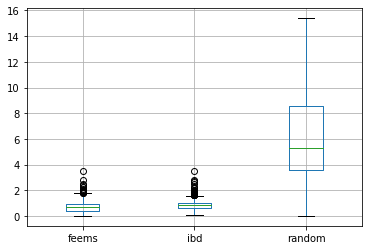

In [201]:
(loo_results1000.reset_index().drop(columns='index')).fillna(10).boxplot()